In [3]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def gamma_trans(img,gamma):
 
    gamma_table = [np.power(x/255.0,gamma)*255.0 for x in range(256)]
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
    #实现映射用的是Opencv的查表函数
    return cv2.LUT(img,gamma_table)
image_path = "/root/autodl-tmp/mvs_training/dtu/Rectified/scan6_train/rect_002_2_r5000.png"
plt.imshow(gamma_trans(image_path,1.5))
plt.show()


In [ ]:
from torch.utils.data import Dataset
import sys
ROOTDIR = "root/autodl-tmp"
sys.path.append(f'/{ROOTDIR}/project/dp_simple/')
from CasMVSNet_pl.datasets.utils import read_pfm
import os
import numpy as np
import cv2
from PIL import Image
import torch
from torchvision import transforms as T


import os
import json
import random
from pathlib import Path
from dataclasses import dataclass
from typing import Literal, Tuple, Optional
import numpy as np
from PIL import Image
from tqdm import tqdm
from cachetools import cached, LRUCache
from cachetools.keys import hashkey

import torch
from torch.utils.data import Dataset
from torchvision.transforms import RandomCrop
from torchvision.transforms.functional import crop
from torch.nn.functional import interpolate

from pytorch3d.renderer.cameras import PerspectiveCameras
from pytorch3d.utils.camera_conversions import opencv_from_cameras_projection
from pytorch3d.io import IO
import sys
import os
path = os.getcwd()
print(path)

@dataclass
class DTUConfig:
    """Arguments for setup of the CO3Dv2_Dataset."""

   
    

    category: Optional[str] = None
    """If specified, only selects this category from the dataset. Can be a comma-separated list of categories as well."""

    subset: Optional[str] = None
    """If specified, only selects images corresponding to this subset. See https://github.com/facebookresearch/co3d for available options."""

    split: Optional[str] = None
    """Must be specified if --subset is specified. Tells which split to use from the subset."""

    max_sequences: int = -1
    """If >-1, randomly select max_sequence sequences per category. Only sequences _with pointclouds_ are selected. Mutually exclusive with --sequence."""

    seed: Optional[int] = 42
    """Random seed for all rng objects"""
 
    split: Optional[str] = None
    """Must be specified if --subset is specified. Tells which split to use from the subset."""

    root_dir: str =f"/{ROOTDIR}/mvs_training/dtu/"
    target_light = 6
    n_views:int=3 
    levels:int=3 
    depth_interval:int =2.65
    img_wh:int=None
    abs_error:Optional[str] ="abs"
    output_total:Optional[bool]=False
    threshold: Optional[int] = 0.8
    prompt_dir: Optional[str] = f"/{ROOTDIR}/mvs_training/dtu/co3d_blip2_captions_final.json"
    debug: Optional[int] = 0
    light_strength: int =  200
    light_gamma: int =  1.2
    dataset_id: str = "eth3d"
    

class DTUDataset(Dataset):
    def __init__(self, config: DTUConfig):
        """
        img_wh should be set to a tuple ex: (1152, 864) to enable test mode!
        """

        self.root_dir = config.root_dir
        self.split = config.split
        assert self.split in ['train', 'val', 'test'], \
            'split must be either "train", "val" or "test"!'
        
        self.dataset_id = config.dataset_id
        
        self.light_class = config.target_light
        self.img_wh = (config.batch.image_width, config.batch.image_height)
        if config.img_wh is not None:
            if type(config.img_wh) is int:
                self.img_wh = (config.img_wh, config.img_wh)
            assert self.img_wh[0]%32==0 and self.img_wh[1]%32==0, \
                'img_wh must both be multiples of 32!'
        self.debug = config.debug
        self.read_bbox()
        self.threshold = config.threshold
        self.build_metas()
        self.n_views = config.n_views
        self.levels = config.levels # FPN levels
        self.depth_interval = config.depth_interval
        self.build_proj_mats()
        self.define_transforms()
        self.output_total = config.output_total
        prompt_dir = config.prompt_dir
        if prompt_dir != None:
            import json
            captions = json.load(open(prompt_dir))
        self.prompt_dir =captions
        
      
        
        
        
    def build_metas(self):
        self.metas = []
        import pickle
        if self.dataset_id == "dtu":
            if self.debug==1:
                self.split = "train"
            with open(f'/{ROOTDIR}/project/dp_simple/CasMVSNet_pl/datasets/lists/dtu/{self.split}.txt') as f:
                self.scans = [line.rstrip() for line in f.readlines()]
            output_pkl = f'/{ROOTDIR}/project/dp_simple/CasMVSNet_pl/datasets/lists/dtu/{self.split}_abs.pkl'
        
            
            with open(output_pkl, 'rb') as f:
                self.output_pkl = pickle.load(f)
            # light conditions 0-6 for training
            # light condition 3 for testing (the brightest?)
            
            outputs_total = {}
            for scan in self.output_pkl.keys():
                scan_index = scan.split('_')[0]
                if scan_index not in outputs_total:
                    outputs_total[scan_index] = []
                outputs_total[scan_index].append(self.output_pkl[scan])
            for scan in outputs_total.keys():
                outputs_total[scan] = np.mean(np.array(outputs_total[scan]), axis=0)
                print(f"scan {scan} mean output: {outputs_total[scan]}")
            self.total_pkl = outputs_total

        
            light_idxs = list(range(7))

            pair_file = "Cameras/pair.txt"
            for scan in self.scans:
                with open(os.path.join(self.root_dir, pair_file)) as f:
                    num_viewpoint = int(f.readline())
                    # viewpoints (49)
                    for _ in range(num_viewpoint):
                        ref_view = int(f.readline().rstrip())
                        src_views = [int(x) for x in f.readline().rstrip().split()[1::2]]
                        

                        for light_idx in light_idxs:
                            output_key = f"{scan}_{ref_view}_{src_views[0]}_{src_views[1]}"
                            losses = self.output_pkl[output_key]
                            if self.split=="train":
                                if self.debug ==1:
                                    if scan == "scan105":
                                        self.metas += [(scan, ref_view,light_idx, src_views,int(np.argmin(losses)))]
                                else:                               
                                    self.metas += [(scan, ref_view,light_idx, src_views,int(np.argmin(losses)))]
                            elif self.split!="train":
                                if light_idx!=0 or scan !="scan106":
                                    continue
                                else:
                                    self.metas += [(scan, ref_view,light_idx, src_views,int(np.argmin(losses)))]
                               
        
        elif self.dataset_id == "eth3d":
            split_path = os.path.join(self.root_dir, f'{self.split}.txt')
            bbox_path = os.path.join(self.root_dir, 'bbox.pkl')
            print("load split text of eth3d: ",split_path)
            print("load bbox of eth3d: ",bbox_path)
            self.metas = []
            import pickle as pkl
            with open(split_path) as f:
                self.scans = [line.rstrip() for line in f.readlines()]
            with open(bbox_path, 'rb') as f:
                self.total_pkl = pickle.load(f)
                
            for scan in self.scans:
                pair_file = "pair.txt"
                print(scan,self.root_dir, pair_file)
                pair_file = os.path.join(self.root_dir, scan, pair_file)
                with open(pair_file,"r") as f:
                    num_viewpoint = int(f.readline())
                    print(f"num_viewpoint: {num_viewpoint}")
                    for _ in range(num_viewpoint):
                        ref_view = int(f.readline().rstrip())
                        src_views = [int(x) for x in f.readline().rstrip().split()[1::2]]
                        
                        self.metas += [(scan, ref_view,None, src_views,None)]
    


            

            
                         
    def build_proj_mats(self):
        proj_mats = []
        if self.dataset_id == "dtu":
            for vid in range(49): # total 49 view ids
                if self.img_wh is None:
                    proj_mat_filename = os.path.join(self.root_dir,
                                                    f'Cameras/train/{vid:08d}_cam.txt')
                else:
                    proj_mat_filename = os.path.join(self.root_dir,
                                                    f'Cameras/{vid:08d}_cam.txt')
                intrinsics, extrinsics, depth_min = \
                    self.read_cam_file(proj_mat_filename)
                if self.img_wh is not None: # resize the intrinsics to the coarsest level
                    intrinsics[0] *= self.img_wh[0]/1600/4
                    intrinsics[1] *= self.img_wh[1]/1200/4
                K = intrinsics
                R = extrinsics
                # multiply intrinsics and extrinsics to get projection matrix
                proj_mat_ls = []
                for l in reversed(range(self.levels)):
                    proj_mat_l = np.eye(4)
                    proj_mat_l[:3, :4] = intrinsics @ extrinsics[:3, :4]
                    intrinsics[:2] *= 2 # 1/4->1/2->1
                    proj_mat_ls += [torch.FloatTensor(proj_mat_l)]
                # (self.levels, 4, 4) from fine to coarse
                proj_mat_ls = torch.stack(proj_mat_ls[::-1])
            
                proj_mats += [(proj_mat_ls, depth_min,K,R)]

            self.proj_mats = proj_mats
        elif self.dataset_id == "eth3d":
            for meta in self.metas:
                scan, ref_view, _, src_views, _ = meta
                camera_file = os.path.join(self.root_dir, scan, f'cams_1/{ref_view:08d}_cam.txt')
                intrinsics, extrinsics, depth_min = self.read_cam_file(camera_file)
                K = intrinsics
                R = extrinsics
                proj_mat_ls = []
                for l in reversed(range(self.levels)):
                    proj_mat_l = np.eye(4)
                    proj_mat_l[:3, :4] = intrinsics @ extrinsics[:3, :4]
                    intrinsics[:2] *= 2 # 1/4->1/2->1
                    proj_mat_ls += [torch.FloatTensor(proj_mat_l)]
                # (self.levels, 4, 4) from fine to coarse
                proj_mat_ls = torch.stack(proj_mat_ls[::-1])
            
                proj_mats += [(proj_mat_ls, depth_min,K,R)]

                self.proj_mats = proj_mats

        
    

    def read_cam_file(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f.readlines()]
        # extrinsics: line [1,5), 4x4 matrix
        extrinsics = np.fromstring(' '.join(lines[1:5]), dtype=np.float32, sep=' ')
        extrinsics = extrinsics.reshape((4, 4))
        # intrinsics: line [7-10), 3x3 matrix
        intrinsics = np.fromstring(' '.join(lines[7:10]), dtype=np.float32, sep=' ')
        intrinsics = intrinsics.reshape((3, 3))
        # depth_min & depth_interval: line 11
        depth_min = float(lines[11].split()[0])
        return intrinsics, extrinsics, depth_min

    def read_depth(self, filename):
        depth = np.array(read_pfm(filename)[0], dtype=np.float32) # (1200, 1600)
        if self.img_wh is None:
            depth = cv2.resize(depth, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST) # (600, 800)
            depth_0 = depth[44:556, 80:720] # (512, 640)
        else:
            depth_0 = cv2.resize(depth, self.img_wh,
                                 interpolation=cv2.INTER_NEAREST)
        depth_1 = cv2.resize(depth_0, None, fx=0.5, fy=0.5,
                             interpolation=cv2.INTER_NEAREST)
        depth_2 = cv2.resize(depth_1, None, fx=0.5, fy=0.5,
                             interpolation=cv2.INTER_NEAREST)

        depths = {"level_0": torch.FloatTensor(depth_0),
                  "level_1": torch.FloatTensor(depth_1),
                  "level_2": torch.FloatTensor(depth_2)}
        
        return depths

    def read_mask(self, filename):
        mask = cv2.imread(filename, 0) # (1200, 1600)
       
        if self.img_wh is None:
            mask = cv2.resize(mask, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST) # (600, 800)
            mask_0 = mask[44:556, 80:720] # (512, 640)
        else:
            mask_0 = cv2.resize(mask, self.img_wh,
                                interpolation=cv2.INTER_NEAREST)
        mask_1 = cv2.resize(mask_0, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)   # 
        mask_2 = cv2.resize(mask_1, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)

        mask_3 = cv2.resize(mask_2, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)


        masks = {"level_0": torch.BoolTensor(mask_0),
                 "level_1": torch.BoolTensor(mask_1),
                 "level_2": torch.BoolTensor(mask_2),
                 "level_3": torch.BoolTensor(mask_3)}

        return masks
    def read_bbox(self):
        import pickle as pkl
        bbox_path = os.path.join(self.root_dir,"bbox.pkl")
        with open(bbox_path, 'rb') as f:
            bbox = pkl.load(f)
        self.bbox = bbox


    def define_transforms(self):
        if self.split == 'train': # you can add augmentation here
            self.transform = T.Compose([T.ToTensor(),
                                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225]),
                                       ])
        else:
            self.transform = T.Compose([T.ToTensor(),
                                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225]),
                                       ])
        self.unpreprocess = T.Compose([
            T.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ])
    
    def decode_batch(self, batch):
        imgs = batch['imgs']
        proj_mats = batch['proj_mats']
        depths = batch['depths']
        masks = batch['masks']
        init_depth_min = batch['init_depth_min']
        depth_interval = batch['depth_interval']
        return imgs, proj_mats, depths, masks, init_depth_min, depth_interval

    def __len__(self):
        return len(self.metas)


    


    def  __getitem__(self, idx):
        if self.dataset_id == "eth3d":
            scan, ref_view,light_idx, src_views,target_light = self.metas[idx]
            task = np.random.choice(["different albedo","overexposed","shadow","different dark"],1)
            
            view_ids = [ref_view] + src_views[:self.n_views-1]
            sample = {}
            imgs = []
            cams = []
            proj_mats = []
            target_imgs = []
            Ks = []
            Rs = []
            intensity_stats =[]
            index = np.random.randn(self.n_views)

            x_min = self.bbox[f"{scan}"]["x_min"]
            x_max = self.bbox[f"{scan}"]["x_max"]
            y_min = self.bbox[f"{scan}"]["y_min"]
            y_max = self.bbox[f"{scan}"]["y_max"]
            z_min = self.bbox[f"{scan}"]["z_min"]
            z_max = self.bbox[f"{scan}"]["z_max"]

            sample['prompt'] = [f"modify the images for task {task}"]
            index = index>0
            for i, vid in enumerate(view_ids):
            # NOTE that the id in image file names is from 1 to 49 (not 0~48)
                if index[i]:
                    img_filename = os.path.join(self.root_dir,
                                    f'{scan}/images/{vid:08d}.jpg')
                else:
                    if task == "different albedo":
                        img_filename = os.path.join(self.root_dir,
                                    f'{scan}/images_albedo/different_albedo_{vid:08d}.jpg')
                    elif task == "different dark":
                        img_filename = os.path.join(self.root_dir,
                                    f'{scan}/images_dark/different_albedo_{vid:08d}.jpg')
                    elif task == "overexposed":
                        img_filename = os.path.join(self.root_dir,
                                    f'{scan}/images_shadow/different_shadow_{vid:08d}.jpg')
                    else:
                        img_filename = os.path.join(self.root_dir,
                                    f'{scan}/images_shadow/different_dark_{vid:08d}.jpg')


                target_filename = os.path.join(self.root_dir,
                                    f'{scan}/images/{vid:08d}.jpg')
                # mask_filename = os.path.join(self.root_dir,
                #                 f'Depths/{scan}/depth_visual_{vid:04d}.png')
                # depth_filename = os.path.join(self.root_dir,
                #                 f'Depths/{scan}/depth_map_{vid:04d}.pfm')
        

                img = Image.open(img_filename)
                target_img = Image.open(target_filename)
                if self.img_wh is not None:
                    img = img.resize(self.img_wh, Image.BILINEAR)
                    target_img = target_img.resize(self.img_wh, Image.BILINEAR)
               
                    

                img = self.transform(img)
                target_img = self.transform(target_img)
                imgs += [img]
                target_imgs += [target_img]

                proj_mat_ls, depth_min,K,R = self.proj_mats[vid]
                Ks += [K]
                Rs += [R]
            



                if i == 0:  # reference view
                    sample["small_mask"]=[]
                    
                    sample['init_depth_min'] = torch.FloatTensor([depth_min])
                    
                    
                    ref_proj_inv = torch.inverse(proj_mat_ls)
                else:
                    # small_mask = self.read_mask(mask_filename)["level_0"]
                    # small_wh = (self.img_wh[0]/8,self.img_wh[1]/8)
                    # sample["small_mask"] = interpolate(small_mask[None,None].float(), small_wh, mode='nearest')[0,0].byte()
                    
                    proj_mats += [proj_mat_ls @ ref_proj_inv]
                var, mean = torch.var_mean(img)
                intensity_stat = torch.stack([mean, var], dim=0)
                intensity_stats.append(intensity_stat)
        
        
            imgs = torch.stack(imgs) # (V, 3, H, W)
            
            target_imgs = torch.stack(target_imgs)
            proj_mats = torch.stack(proj_mats)[:,:,:3] # (V-1, self.levels, 3, 4) from fine to coarse
            
            imgs = self.unpreprocess(imgs)
            target_imgs = self.unpreprocess(target_imgs)
            
            
            



        
            Ks = np.stack(Ks)
            Rs = np.stack(Rs)
            sample['pose'] = Rs
            sample['K'] = Ks
            sample['images'] = imgs
            
            

            sample["intensity_stats"] = torch.stack(intensity_stats)
            sample['proj_mats'] = proj_mats
            sample['depth_interval'] = torch.FloatTensor([self.depth_interval])
            sample['scan_vid'] = (scan, ref_view)
            

            sample['target_imgs'] = target_imgs

            sample["bbox"] =torch.tensor([[x_min,y_min,z_min], 
                                        [x_max,y_max,z_max]], dtype=torch.float32)




            return sample




        else:
            scan, ref_view,light_idx, src_views,target_light = self.metas[idx]
            # use only the reference view and first nviews-1 source views
            # shuffle the source views

            view_ids = [ref_view] + src_views[:self.n_views-1]
            light_input = np.random.choice(7,1)
            light_bright_sign = light_input[0] - light_idx
            input_lights=[light_idx,light_idx,light_idx]
            target_light = target_light



            # output_key = f"{scan}_{ref_view}_{src_views[0]}_{src_views[1]}"
            # if self.total_pkl:
            #     target_light = self.total_pkl[scan]
            #     target_light = np.argmin(target_light)
            # else:
            #     target_light = self.output_pkl[output_key]
            #     target_light = np.argmin(target_light)

            

            sample = {}
            imgs = []
            cams = []
            proj_mats = []
            target_imgs = []
            Ks = []
            Rs = []
            intensity_stats =[]
            prompt = str(np.random.choice(self.prompt_dir[scan][str(ref_view)],1)[0])

            x_min = self.bbox[f"{scan}_train"]["x"]["min"]
            x_max = self.bbox[f"{scan}_train"]["x"]["max"]
            y_min = self.bbox[f"{scan}_train"]["y"]["min"]
            y_max = self.bbox[f"{scan}_train"]["y"]["max"]
            z_min = self.bbox[f"{scan}_train"]["z"]["min"]
            z_max = self.bbox[f"{scan}_train"]["z"]["max"]

            sample['prompt'] = [f"modify the lightness of image to light_class_{light_idx} style"]
            for i, vid in enumerate(view_ids):
            # NOTE that the id in image file names is from 1 to 49 (not 0~48)
            
                img_filename = os.path.join(self.root_dir,
                                f'Rectified/{scan}_train/rect_{vid+1:03d}_{input_lights[i]}_r5000.png')
                target_filename = os.path.join(self.root_dir,
                                f'Rectified/{scan}_train/rect_{vid+1:03d}_{target_light}_r5000.png')
                mask_filename = os.path.join(self.root_dir,
                                f'Depths/{scan}/depth_visual_{vid:04d}.png')
                depth_filename = os.path.join(self.root_dir,
                                f'Depths/{scan}/depth_map_{vid:04d}.pfm')
        

                img = Image.open(img_filename)
                target_img = Image.open(target_filename)
                if self.img_wh is not None:
                    img = img.resize(self.img_wh, Image.BILINEAR)
                    target_img = target_img.resize(self.img_wh, Image.BILINEAR)
                if input_lights[i] != target_light:
                    # make image brighter or darker
                    img = np.array(img)
                    if input_lights[i] > target_light:
                        # increase contrast and the image looks 
                        alpha = np.random.uniform(1.5, 2.5)
                        beta = np.random.uniform(10, 30)
                        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
                    else:
                        alpha = np.random.uniform(0.15, 0.75)
                        beta = np.random.uniform(-30, -10)
                        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
                        
                    

                img = self.transform(img)
                target_img = self.transform(target_img)
                imgs += [img]
                target_imgs += [target_img]

                proj_mat_ls, depth_min,K,R = self.proj_mats[vid]
                Ks += [K]
                Rs += [R]
            



                if i == 0:  # reference view
                    sample["small_mask"]=[]
                    
                    sample['init_depth_min'] = torch.FloatTensor([depth_min])
                    
                    sample['masks'] = self.read_mask(mask_filename)
                    for key in sample['masks']:
                        sample['masks'][key] = sample['masks'][key]
                    sample['depths'] = self.read_depth(depth_filename)
                    for key in sample['depths']:
                        sample['depths'][key] = sample['depths'][key]
                    sample["depth"] = sample["depths"]["level_0"]
                    ref_proj_inv = torch.inverse(proj_mat_ls)
                else:
                    # small_mask = self.read_mask(mask_filename)["level_0"]
                    # small_wh = (self.img_wh[0]/8,self.img_wh[1]/8)
                    # sample["small_mask"] = interpolate(small_mask[None,None].float(), small_wh, mode='nearest')[0,0].byte()
                    
                    proj_mats += [proj_mat_ls @ ref_proj_inv]
                var, mean = torch.var_mean(img)
                intensity_stat = torch.stack([mean, var], dim=0)
                intensity_stats.append(intensity_stat)
        
        
            imgs = torch.stack(imgs) # (V, 3, H, W)
            
            target_imgs = torch.stack(target_imgs)
            proj_mats = torch.stack(proj_mats)[:,:,:3] # (V-1, self.levels, 3, 4) from fine to coarse
            
            imgs = self.unpreprocess(imgs)
            target_imgs = self.unpreprocess(target_imgs)
            
            
            img_mask = (imgs-target_imgs).abs().mean(1,keepdim=True).repeat(1,3,1,1)



        
            Ks = np.stack(Ks)
            Rs = np.stack(Rs)
            sample['pose'] = Rs
            sample['K'] = Ks
            sample['images'] = imgs
            
            

            sample["intensity_stats"] = torch.stack(intensity_stats)
            sample['proj_mats'] = proj_mats
            sample['depth_interval'] = torch.FloatTensor([self.depth_interval])
            sample['scan_vid'] = (scan, ref_view)
            

            sample['target_imgs'] = target_imgs
            small_mask = sample["masks"]["level_0"]
            small_wh = (80,64)
            sample["class"] = torch.tensor([light_idx])
            sample["small_mask"] = interpolate(small_mask[None,None].float(), small_wh, mode='nearest')[0,0].byte()

            sample["bbox"] =torch.tensor([[x_min,y_min,z_min], 
                                        [x_max,y_max,z_max]], dtype=torch.float32)




            return sample







In [1]:
class dataconfig:
    root_dir ="/openbayes/input/input0/mvs_training/dtu/"
    split = "val"

    target_light = 6
    n_views:int=3 
    levels:int=3 
    depth_interval:int =2.65
    img_wh:int=None
    abs_error:Optional[str] ="abs"
    output_total:Optional[bool]=False
    threshold: Optional[int] = 4.7
    prompt_dir: Optional[str] = "/openbayes/input/input0/mvs_training/dtu/co3d_blip2_captions_final.json"


NameError: name 'Optional' is not defined

: 

In [6]:
val_data = DTUDataset(dataconfig)

scan scan3 mean output: [3.05263341 2.92222905 2.79727794 2.86347311 2.84872966 2.86011306
 2.89029897]
scan scan5 mean output: [1.27925969 1.21662743 1.19024779 1.17714057 1.17585228 1.13693983
 1.13944231]
scan scan17 mean output: [4.23918102 4.3646479  4.26873698 4.152941   4.16164234 4.44407791
 4.15546879]
scan scan21 mean output: [6.7044504  6.78296111 6.79752936 6.78882487 6.74292021 6.64370545
 6.71224226]
scan scan28 mean output: [8.33500304 8.26974845 8.08564879 7.80853114 7.63656337 7.53135754
 7.33638762]
scan scan35 mean output: [1.18667069 1.32775589 1.20760566 1.06743625 1.15983699 0.91010288
 0.87788923]
scan scan37 mean output: [21.1885944  21.17826699 21.25191359 21.18731575 20.97766127 20.14655309
 19.91200681]
scan scan38 mean output: [1.69360119 1.60652492 1.57134287 1.54112932 1.56236016 1.63116413
 1.62020702]
scan scan40 mean output: [3.64535844 3.69948315 3.71793726 3.69029421 3.68635351 3.71370282
 3.58273512]
scan scan43 mean output: [2.2589177  2.24700747 2.

In [7]:
class runfig:
    pretrained_model_name_or_path = "/openbayes/input/input0/ViewDiff/viewdiff/output_var_unproj/all/subset_all/input_3/train/class6/saved_model_from_checkpoint-30000"
    n_input_images =3
    n_output_noise =3

In [8]:
config_path = config_path = os.path.join(runfig.pretrained_model_name_or_path, "config.json")
if not os.path.isfile(str(config_path)):
        raise ValueError("cannot find config.json in ", config_path)
with open(config_path, "r") as f:
    config_data = json.load(f)
finetune_config = from_dict(FinetuneConfig, data=config_data, config=Config(cast=[tuple, int]))
runfig.cross_frame_attention = finetune_config.cross_frame_attention
runfig.model = finetune_config.model


In [9]:
pipeline = CustomInstructPix2pixDiffusionPipeline.from_pretrained(
        runfig.pretrained_model_name_or_path
    )
pipeline.scheduler.config.prediction_type = finetune_config.training.noise_prediction_type

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing UNet2DConditionCrossFrameInExistingAttnModel: 
 ['down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.0.bias, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.0.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.2.bias, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.2.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_k_lora.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_k_lora.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_out_lora.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_out_lora.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.up.weight, down_blocks.0.attentions.0.tr

In [10]:
replace_self_attention_with_cross_frame_attention(
                unet=pipeline.unet,
                n_input_images=runfig.n_input_images,
                to_k_other_frames=runfig.cross_frame_attention.to_k_other_frames,
                with_self_attention=runfig.cross_frame_attention.with_self_attention,
                random_others=runfig.cross_frame_attention.random_others,
                use_lora_in_cfa="cfa" in runfig.model.pose_cond_mode or "sa" in runfig.model.pose_cond_mode,
                use_temb_in_lora=runfig.cross_frame_attention.use_temb_cond,
                temb_out_size=8,
                pose_cond_dim=runfig.model.pose_cond_dim,
                rank=runfig.model.pose_cond_lora_rank,
            )

({},
 [Parameter containing:
  tensor([[-0.0118,  0.0084,  0.0051,  ..., -0.0210, -0.0265, -0.0015],
          [-0.0140, -0.0180, -0.0031,  ..., -0.0159,  0.0154, -0.0153],
          [ 0.0257, -0.0125, -0.0189,  ..., -0.0024,  0.0272, -0.0265],
          ...,
          [-0.0219,  0.0037, -0.0244,  ..., -0.0257,  0.0009, -0.0011],
          [-0.0158,  0.0164,  0.0130,  ...,  0.0220,  0.0177, -0.0018],
          [-0.0244, -0.0125, -0.0229,  ...,  0.0193,  0.0164, -0.0277]],
         requires_grad=True),
  Parameter containing:
  tensor([ 7.8040e-03, -9.3361e-03,  1.4868e-02,  1.3786e-02, -1.3927e-02,
          -3.9787e-03,  2.5464e-02,  8.4288e-03,  1.5691e-02, -7.5140e-03,
          -1.1717e-02,  6.0373e-03,  2.5904e-02,  1.2387e-02,  1.0751e-02,
          -2.4538e-02,  1.0398e-02,  2.2630e-02,  2.2949e-02, -2.7898e-02,
          -2.2873e-02, -8.7320e-03, -1.5098e-02, -1.8688e-03,  5.9387e-03,
           2.2646e-02, -8.8073e-03, -2.7867e-02,  2.3183e-02,  9.7631e-04,
          -1.5867e-

In [11]:
runfig.cross_frame_attention.last_layer_mode,finetune_config.training.changed_cfa_last_layer

('no_residual_connection', 'no_residual_connection')

In [12]:
runfig.cross_frame_attention.with_self_attention,runfig.cross_frame_attention.random_others,

(True, True)

In [13]:
def update_cfa_config(
   
    pipeline: CustomInstructPix2pixDiffusionPipeline,
):
    if runfig.cross_frame_attention.mode == "add_in_existing_block":
        update_cross_frame_attention_config(
            pipeline.unet,
            runfig.n_input_images,
            runfig.cross_frame_attention.to_k_other_frames,
            runfig.cross_frame_attention.with_self_attention,
            runfig.cross_frame_attention.random_others,
            change_self_attention_layers=False,  # should have custom cfa layers
        )
    elif runfig.cross_frame_attention.mode == "pretrained":
        update_cross_frame_attention_config(
            pipeline.unet,
            3,
            2,
            runfig.cross_frame_attention.with_self_attention,
            runfig.cross_frame_attention.random_others,
            change_self_attention_layers=True,  # should have cfa is sa layers
        )
    else:
        raise NotImplementedError(
            f"did not implement different n_input_images for cfa.mode={runfig.cross_frame_attention.mode}"
        )

In [14]:
if finetune_config.training.changed_cfa_last_layer != runfig.cross_frame_attention.last_layer_mode:
        print("Change last-layer-mode to", finetune_config.training.changed_cfa_last_layer)
        update_last_layer_mode(
            pipeline.unet,
            finetune_config.training.changed_cfa_last_layer,
        )
update_vol_rend_inject_noise_sigma(
        pipeline.unet, 0.0
    )
    # disable n_novel_images
update_n_novel_images(
        pipeline.unet, 0

    )
update_cfa_config(pipeline)

In [15]:
if runfig.model.pose_cond_mode != "none":
        # Set correct lora layers
        unet_lora_attn_procs, unet_lora_parameters = add_pose_cond_to_attention_layers(
            pipeline.unet,
            rank=runfig.model.pose_cond_lora_rank,
            pose_cond_dim=runfig.model.pose_cond_dim,
            only_cross_attention="sa" not in runfig.model.pose_cond_mode,
        )

        if unet_lora_parameters is not None:
            in_dir = os.path.join(runfig.pretrained_model_name_or_path, "unet")
            try:
                lora_state_dict, network_alpha = LoraLoaderMixin.lora_state_dict(in_dir, weight_name="pytorch_lora_weights.safetensors")
            except:
                lora_state_dict, network_alpha = LoraLoaderMixin.lora_state_dict(in_dir, weight_name="pytorch_lora_weights.bin")
            lora_state_dict = {k.replace("unet.", ""): v for k, v in lora_state_dict.items()}
            pipeline.unet.load_state_dict(lora_state_dict, strict=False)
            print("Loaded LoRA weights into model")

Loaded LoRA weights into model


In [16]:
pipeline = pipeline.to("cuda")

In [17]:
runfig.model.pose_cond_mode

'sa-ca'

In [18]:
import torch
@torch.no_grad()
def process_batch(
    
   
    pipeline,
   
    batch,
    guidance_scale=8,
    image_guidance_scale: float = 2.0,
    
):
    
    model_config=runfig.model
    cfa_config=runfig.cross_frame_attention
    io_config=runfig
    orig_hw=(512, 640)
    num_inference_steps=50
    n_repeat_generation=1
    generator = torch.Generator("cuda").manual_seed(42)

    # combine
    
    batch["images"] = batch["images"].to("cuda").unsqueeze(0)
    batch["target_imgs"] = batch["target_imgs"].to("cuda").unsqueeze(0) 
    batch["pose"] = batch["pose"].to("cuda").unsqueeze(0)
    batch["K"] = batch["K"].to("cuda").unsqueeze(0)
    batch["intensity_stats"] = batch["intensity_stats"].to("cuda").unsqueeze(0)
    batch["bbox"] = batch["bbox"].to("cuda").unsqueeze(0)

    # check if need to change n_input_images
    if runfig.n_input_images != batch["pose"].shape[1]:
        runfig.n_input_images = batch["pose"].shape[1]
        runfig.cross_frame_attention.to_k_other_frames = batch["pose"].shape[1] - 1
        runfig.model.n_input_images = batch["pose"].shape[1]
        update_cfa_config(runfig, pipeline)

    # alwasy set to 0
    batch["intensity_stats"] *= 0

    # create images
    batch_size = len(batch["prompt"])

    batch["images"] = 2*batch["images"]-1
    batch["target_imgs"] = 2*batch["target_imgs"]-1
    # parse batch
    # collapse K dimension into batch dimension (no concatenation happening)
    batch["prompt"] = [cap for cap in batch["prompt"]]
    prompt = collapse_prompt_to_batch_dim(batch["prompt"],3)
   
    
    _, pose = collapse_tensor_to_batch_dim(batch["pose"])
    _, K = collapse_tensor_to_batch_dim(batch["K"])
    _, intensity_stats = collapse_tensor_to_batch_dim(batch["intensity_stats"])
    bbox = batch["bbox"]

    _, known_images = collapse_tensor_to_batch_dim(batch["images"])
    known_images = known_images.to(pipeline.device)
    known_images = known_images.squeeze(1)
    print(known_images.shape)

    K = K.squeeze(1)[..., :3, :3]
    pose = pose.squeeze(1)
    intensity_stats = intensity_stats.squeeze(1)

    # build cross_attention_kwargs
    cross_attention_kwargs = build_cross_attention_kwargs(
        model_config=runfig.model,
        cfa_config=runfig.cross_frame_attention,
        pose=pose,
        K=K,
        intensity_stats=intensity_stats,
        bbox=bbox,
        orig_hw=orig_hw,
    )
    if "pose_cond" in cross_attention_kwargs:
            cross_attention_kwargs["pose_cond"] = torch.cat([cross_attention_kwargs["pose_cond"]] * 3)
    if "unproj_reproj_kwargs" in cross_attention_kwargs:
        proj_kwargs = cross_attention_kwargs["unproj_reproj_kwargs"]
        proj_kwargs["pose"] = torch.cat([proj_kwargs["pose"]] * 3)
        proj_kwargs["K"] = torch.cat([proj_kwargs["K"]] * 3)
        proj_kwargs["bbox"] = torch.cat([proj_kwargs["bbox"]] * 3)

    outputs = []
    all_psnrs = []
    all_lpipses = []
    all_ssims = []
    for _ in range(n_repeat_generation):
        output = pipeline(
            prompt=prompt,
            height=orig_hw[0],
            width=orig_hw[1],
            known_images=known_images,
            output_type="pt",  # return tensor normalized to [0, 1]
            generator=generator,
            cross_attention_kwargs=cross_attention_kwargs,
            guidance_scale=guidance_scale,
            image_guidance_scale=image_guidance_scale,
            decode_all_timesteps=True,
            num_inference_steps=num_inference_steps,
            n_images_per_batch=model_config.n_input_images,
        )

        # re-create K dimension from batch dimension
        output.images = output.images.unsqueeze(1)
        expand_output_to_k(output, batch_size, model_config.n_input_images)

        outputs.append(output)
   



    

    return outputs



In [19]:
batch = val_data[0]
outputs = process_batch(pipeline, batch)


torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 8,image_guidance: 2.0


  0%|          | 0/50 [00:00<?, ?it/s]

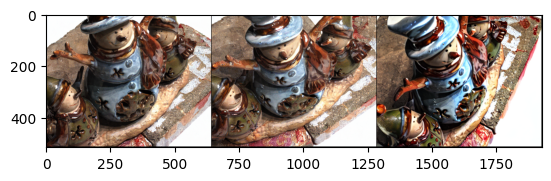

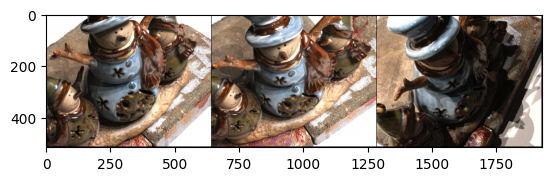

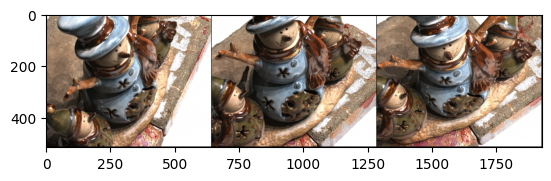

In [20]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
save_image(outputs[0].images[0], "output.png")
batch = val_data[0]

save_image(batch["images"], "input.png")
save_image(batch["target_imgs"], "target.png")

plt.imshow(plt.imread("output.png"))
plt.show()
plt.imshow(plt.imread("input.png"))
plt.show()
plt.imshow(plt.imread("target.png"))
plt.show()

In [21]:
from pandas import DataFrame
df = DataFrame(val_data.metas,columns=["scan","ref_view","light_idx","src_views","target_light"])    
df.head()                                       

,scan,ref_view,light_idx,src_views,target_light
0,scan3,0,0,"[10, 1, 9, 12, 11, 13, 2, 8, 14, 27]",6
1,scan3,0,1,"[10, 1, 9, 12, 11, 13, 2, 8, 14, 27]",6
2,scan3,0,2,"[10, 1, 9, 12, 11, 13, 2, 8, 14, 27]",6
3,scan3,0,3,"[10, 1, 9, 12, 11, 13, 2, 8, 14, 27]",6
4,scan3,0,4,"[10, 1, 9, 12, 11, 13, 2, 8, 14, 27]",6


In [22]:
df["scan"].unique()

array(['scan3', 'scan5', 'scan17', 'scan21', 'scan28', 'scan35', 'scan37',
       'scan38', 'scan40', 'scan43', 'scan56', 'scan59', 'scan66',
       'scan67', 'scan82', 'scan86', 'scan106', 'scan117'], dtype=object)

In [23]:
from math import sqrt
import sys
sys.path.append('/openbayes/home/project/dp_simple/')
#import ViT
from torchvision import transforms as T
from CasMVSNet_pl.models.mvsnet import CascadeMVSNet
from CasMVSNet_pl.utils import load_ckpt
from CasMVSNet_pl.datasets.dtu import DTUDataset  
from CasMVSNet_pl.utils import *
from CasMVSNet_pl.datasets.dtu import DTUDataset 
from CasMVSNet_pl.metrics import *  
from inplace_abn import ABN


import pytorch_lightning as pl

import pytorch_lightning as pl
import sys


import matplotlib.pyplot as plt

import functools
import torch.nn.functional as F
import torch
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import sys
from einops import rearrange
from torchvision import models
import sys

from CasMVSNet_pl.datasets.utils import save_pfm, read_pfm
import cv2
import torch
import os, shutil
import numpy as np
from tqdm import tqdm
from argparse import ArgumentParser

# for depth prediction
from CasMVSNet_pl.models.mvsnet import CascadeMVSNet
from CasMVSNet_pl.utils import load_ckpt
from inplace_abn import ABN

# for point cloud fusion
from numba import jit
from plyfile import PlyData, PlyElement

torch.backends.cudnn.benchmark = True # this increases inference speed a little

In [24]:
torch.backends.cudnn.benchmark = True # this increases inference speed a little

def get_opts():
    parser = ArgumentParser()
    parser.add_argument('--root_dir', type=str,
                        default='/openbayes/input/input0/mvs_training/dtu',
                        help='root directory of dtu dataset')
    parser.add_argument('--dataset_name', type=str, default='dtu',
                        choices=['dtu', 'tanks', 'blendedmvs'],
                        help='which dataset to train/val')
    parser.add_argument('--split', type=str, default='train',
                        help='which split to evaluate')
    parser.add_argument('--scan', type=str, default='scan7',
                        help='specify scan to evaluate (must be in the split)')
    parser.add_argument('--cpu', default=False, action='store_true',
                        help='''use cpu to do depth inference.
                                WARNING: It is going to be EXTREMELY SLOW!
                                about 37s/view, so in total 30min/scan. 
                             ''')
    # for depth prediction
    parser.add_argument('--n_views', type=int, default=3,
                        help='number of views (including ref) to be used in testing')
    parser.add_argument('--depth_interval', type=float, default=2.65,
                        help='depth interval unit in mm')
    parser.add_argument('--n_depths', nargs='+', type=int, default=[8,32,48],
                        help='number of depths in each level')
    parser.add_argument('--interval_ratios', nargs='+', type=float, default=[1.0,2.0,4.0],
                        help='depth interval ratio to multiply with --depth_interval in each level')
    parser.add_argument('--num_groups', type=int, default=8, choices=[1, 2, 4, 8],
                        help='number of groups in groupwise correlation, must be a divisor of 8')
    parser.add_argument('--img_wh', nargs="+", type=int, default=[640,512],
                        help='resolution (img_w, img_h) of the image, must be multiples of 32')
    parser.add_argument('--ckpt_path', type=str, default='/openbayes/input/input0/project/dp_simple/CasMVSNet_pl/ckpts/_ckpt_epoch_10.ckpt',
                        help='pretrained checkpoint path to load')
    parser.add_argument('--save_visual', default=False, action='store_true',
                        help='save depth and proba visualization or not')

    # for point cloud fusion
    parser.add_argument('--conf', type=float, default=0.999,
                        help='min confidence for pixel to be valid')
    parser.add_argument('--min_geo_consistent', type=int, default=5,
                        help='min number of consistent views for pixel to be valid')
    parser.add_argument('--max_ref_views', type=int, default=400,
                        help='max number of ref views (to limit RAM usage)')
    parser.add_argument('--skip', type=int, default=1,
                        help='''how many points to skip when creating the point cloud.
                                Larger = fewer points and smaller file size.
                                Ref: skip=10 creates ~= 3M points = 50MB file
                                     skip=1 creates ~= 30M points = 500MB file
                             ''')
    args, _ = parser.parse_known_args()
    return args
  
    

In [25]:
def decode_batch(batch):
    imgs = batch['images']
    proj_mats = batch['proj_mats']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    scan, vid = batch['scan_vid']
    return imgs, proj_mats, init_depth_min, depth_interval, \
           scan, vid


# define read_image and read_proj_mat for each dataset

def read_image(dataset_name, root_dir, scan, vid,light):
    if dataset_name == 'dtu':
        return cv2.imread(os.path.join(root_dir,
                    f'Rectified/{scan}_train/rect_{vid+1:03d}_{light}_r5000.png'))
    if dataset_name == 'tanks':
        return cv2.imread(os.path.join(root_dir, scan,
                    f'images/{vid:08d}.jpg'))
    if dataset_name == 'blendedmvs':
        return cv2.imread(os.path.join(root_dir, scan,
                    f'blended_images/{vid:08d}.jpg'))


def read_refined_image(dataset_name, scan, vid):
    return cv2.imread(f'results/{dataset_name}/image_refined/{scan}/{vid:08d}.png')


def save_refined_image(image_refined, dataset_name, scan, vid):
    cv2.imwrite(f'results/{dataset_name}/image_refined/{scan}/{vid:08d}.png',
                image_refined)


def read_proj_mat(dataset_name, dataset, scan, vid):
    if dataset_name == 'dtu':
        return dataset.proj_mats[vid][0][0].numpy()
    if dataset_name in ['tanks', 'blendedmvs']:
        return dataset.proj_mats[scan][vid][0][0].numpy()


@jit(nopython=True, fastmath=True)
def xy_ref2src(xy_ref, depth_ref, P_world2ref,
               depth_src, P_world2src, img_wh):
    # create ref grid and project to ref 3d coordinate using depth_ref
    xyz_ref = np.vstack((xy_ref, np.ones_like(xy_ref[:1]))) * depth_ref
    xyz_ref_h = np.vstack((xyz_ref, np.ones_like(xy_ref[:1])))

    P = (P_world2src @ np.ascontiguousarray(np.linalg.inv(P_world2ref)))[:3]
    # project to src 3d coordinate using P_world2ref and P_world2src
    xyz_src_h = P @ xyz_ref_h.reshape(4,-1)
    xy_src = xyz_src_h[:2]/xyz_src_h[2:3]
    xy_src = xy_src.reshape(2, img_wh[1], img_wh[0])

    return xy_src


@jit(nopython=True, fastmath=True)
def xy_src2ref(xy_ref, xy_src, depth_ref, P_world2ref,
               depth_src2ref, P_world2src, img_wh):
    # project xy_src back to ref view using the sampled depth
    xyz_src = np.vstack((xy_src, np.ones_like(xy_src[:1]))) * depth_src2ref
    xyz_src_h = np.vstack((xyz_src, np.ones_like(xy_src[:1])))
    P = (P_world2ref @ np.ascontiguousarray(np.linalg.inv(P_world2src)))[:3]
    xyz_ref_h = P @ xyz_src_h.reshape(4,-1)
    depth_ref_reproj = xyz_ref_h[2].reshape(img_wh[1], img_wh[0])
    xy_ref_reproj = xyz_ref_h[:2]/xyz_ref_h[2:3]
    xy_ref_reproj = xy_ref_reproj.reshape(2, img_wh[1], img_wh[0])

    # check |p_reproj-p_1| < 1
    pixel_diff = xy_ref_reproj - xy_ref
    mask_pixel_reproj = (pixel_diff[0]**2+pixel_diff[1]**2)<1

    # check |d_reproj-d_1| / d_1 < 0.01
    mask_depth_reproj = np.abs((depth_ref_reproj-depth_ref)/depth_ref)<0.01

    mask_geo = mask_pixel_reproj & mask_depth_reproj

    return depth_ref_reproj, mask_geo


def check_geo_consistency(depth_ref, P_world2ref,
                          depth_src, P_world2src,
                          image_ref, image_src,
                          img_wh):
    """
    Check the geometric consistency between ref and src views.
    """
    xy_ref = np.mgrid[:img_wh[1],:img_wh[0]][::-1].astype(np.float32)
    xy_src = xy_ref2src(xy_ref, depth_ref, P_world2ref,
                        depth_src, P_world2src, img_wh)

    # Sample the depth of xy_src using bilinear interpolation
    depth_src2ref = cv2.remap(depth_src,
                              xy_src[0].astype(np.float32),
                              xy_src[1].astype(np.float32),
                              interpolation=cv2.INTER_LINEAR)

    image_src2ref = cv2.remap(image_src,
                              xy_src[0].astype(np.float32),
                              xy_src[1].astype(np.float32),
                              interpolation=cv2.INTER_LINEAR)

    depth_ref_reproj, mask_geo = \
        xy_src2ref(xy_ref, xy_src, depth_ref, P_world2ref, 
                   depth_src2ref, P_world2src, img_wh)

    depth_ref_reproj[~mask_geo] = 0
    image_src2ref[~mask_geo] = 0
    
    return depth_ref_reproj, mask_geo, image_src2ref

In [26]:
def abs_error(depth_pred, depth_gt, mask):
    depth_pred, depth_gt = depth_pred[mask], depth_gt[mask]
    return np.abs(depth_pred - depth_gt)

def acc_threshold(depth_pred, depth_gt, mask, threshold):
    """
    computes the percentage of pixels whose depth error is less than @threshold
    """
    errors = abs_error(depth_pred, depth_gt, mask)
    acc_mask = errors < threshold
    return acc_mask.mean()

def return_log(result1,result2,gt_depth,mask):
    depth_pred = result1["depth_0"][0].cpu().numpy()
    ori_pred = result2["depth_0"][0].cpu().numpy()

    print(depth_pred.shape, ori_pred.shape, gt_depth.shape, mask.shape)
    

    abs_error1 = abs_error(depth_pred, gt_depth, mask).mean()
    abs_error2 = abs_error(ori_pred, gt_depth, mask).mean()
    print(f"depth modified is {abs_error1},original error is {abs_error2} ")
    abs_diff = abs_error1 - abs_error2
    abs_ratio = abs_error1 / abs_error2

    acc1mm1 = acc_threshold(depth_pred, gt_depth, mask, 1)
    acc1mm2 = acc_threshold(ori_pred, gt_depth, mask, 1)
    acc_diff = acc1mm1 - acc1mm2
    acc_ratio = acc1mm1 / (acc1mm2+1e-7)

    acc2mm1 = acc_threshold(depth_pred, gt_depth, mask, 2)
    acc2mm2 = acc_threshold(ori_pred, gt_depth, mask, 2)
    acc_diff2 = acc2mm1 - acc2mm2
    acc_ratio2 = acc2mm1 / (acc2mm2+1e-7)

    acc3mm1 = acc_threshold(depth_pred, gt_depth, mask, 3)
    acc3mm2 = acc_threshold(ori_pred, gt_depth, mask, 3)
    acc_diff3 = acc3mm1 - acc3mm2
    acc_ratio3 = acc3mm1 / (acc3mm2+1e-7)

    acc4mm1 = acc_threshold(depth_pred, gt_depth, mask, 4)
    acc4mm2 = acc_threshold(ori_pred, gt_depth, mask, 4)
    acc_diff4 = acc4mm1 - acc4mm2
    acc_ratio4 = acc4mm1 / (acc4mm2+1e-7)

    return {"abs_diff":abs_diff,"abs_ratio":abs_ratio,"acc_diff1":acc_diff,"acc_ratio1":acc_ratio,
            "acc_diff2":acc_diff2,"acc_ratio2":acc_ratio2,"acc_diff3":acc_diff3,"acc_ratio3":acc_ratio3,
            "acc_diff4":acc_diff4,"acc_ratio4":acc_ratio4}



In [27]:
args = get_opts()

In [28]:
model = CascadeMVSNet(n_depths=args.n_depths,
                        interval_ratios=args.interval_ratios,
                        num_groups=1,
                        norm_act=ABN)
device = 'cpu' if args.cpu else 'cuda:0'
model.to(device)
load_ckpt(model, args.ckpt_path)
model.eval()


CascadeMVSNet(
  (feature): FeatureNet(
    (conv0): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
    )
    (conv1): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (2): ConvBnReLU(
        (conv): Conv2d(16, 16, k

In [29]:
val_data[0]["depths"]["level_0"].shape

torch.Size([512, 640])

In [ ]:
transform = T.Compose([T.Normalize(mean=[0.485, 0.456, 0.406], 
std=[0.229, 0.224, 0.225])])

In [ ]:
refine = True
read_gt = False

In [ ]:
args.save_visual=True   

In [ ]:
val_data.metas

[('scan3', 0, 0, [10, 1, 9, 12, 11, 13, 2, 8, 14, 27], 6),
 ('scan3', 0, 1, [10, 1, 9, 12, 11, 13, 2, 8, 14, 27], 6),
 ('scan3', 0, 2, [10, 1, 9, 12, 11, 13, 2, 8, 14, 27], 6),
 ('scan3', 0, 3, [10, 1, 9, 12, 11, 13, 2, 8, 14, 27], 6),
 ('scan3', 0, 4, [10, 1, 9, 12, 11, 13, 2, 8, 14, 27], 6),
 ('scan3', 0, 5, [10, 1, 9, 12, 11, 13, 2, 8, 14, 27], 6),
 ('scan3', 0, 6, [10, 1, 9, 12, 11, 13, 2, 8, 14, 27], 6),
 ('scan3', 1, 0, [9, 10, 2, 0, 8, 13, 14, 12, 7, 15], 0),
 ('scan3', 1, 1, [9, 10, 2, 0, 8, 13, 14, 12, 7, 15], 0),
 ('scan3', 1, 2, [9, 10, 2, 0, 8, 13, 14, 12, 7, 15], 0),
 ('scan3', 1, 3, [9, 10, 2, 0, 8, 13, 14, 12, 7, 15], 0),
 ('scan3', 1, 4, [9, 10, 2, 0, 8, 13, 14, 12, 7, 15], 0),
 ('scan3', 1, 5, [9, 10, 2, 0, 8, 13, 14, 12, 7, 15], 0),
 ('scan3', 1, 6, [9, 10, 2, 0, 8, 13, 14, 12, 7, 15], 0),
 ('scan3', 2, 0, [8, 1, 7, 9, 3, 15, 14, 16, 6, 10], 5),
 ('scan3', 2, 1, [8, 1, 7, 9, 3, 15, 14, 16, 6, 10], 5),
 ('scan3', 2, 2, [8, 1, 7, 9, 3, 15, 14, 16, 6, 10], 5),
 ('scan3',

In [ ]:

print('Creating depth and confidence predictions...')
for scan in ['scan3', 'scan5', 'scan17', 'scan21', 'scan28', 'scan35', 'scan37',
       'scan38', 'scan40', 'scan43', 'scan56', 'scan59', 'scan66',
       'scan67', 'scan82', 'scan117']:
    depth_dir = f'./results/{args.dataset_name}/depth'
    depth_dir = os.path.join(depth_dir, scan)

    img_dir = f'./results/{args.dataset_name}/image_modified'
    img_dir = os.path.join(img_dir, scan)

    os.makedirs(depth_dir, exist_ok=True)
    os.makedirs(img_dir, exist_ok=True)

    abs_ratio = []
    acc_ratio1 = []
    acc_ratio2 = []
    acc_ratio3 = []
    acc_ratio4 = []
    acc_diff1 = []
    acc_diff2 = []
    acc_diff3 = []
    acc_diff4 = []
    abs_diff = []

    target_diff=[]
    target_ratio=[]

    data_range = [i for i, x in enumerate(val_data.metas) if x[0] == scan and x[2]==6]
    print(f'Processing {scan} with {len(data_range)} views')
    for i in tqdm(data_range):
        batch =  val_data[i]
       
        imgs, proj_mats, init_depth_min, depth_interval, \
            scan, vid = decode_batch(batch)
        src1 = vid[1]
        src2 = vid[2]
        vid = vid[0]
        
        proj_mats = proj_mats.unsqueeze(0).to("cuda")
        imgs = imgs.unsqueeze(0).to(device)
        target_imgs = batch["target_imgs"].unsqueeze(0).to("cuda")

        
        
           
       
        
        
        
        os.makedirs(os.path.join(depth_dir, scan), exist_ok=True)

        with torch.no_grad():
           
            
            
            if refine == True:
                # whether image exist or not
                ref_path = os.path.join(img_dir, f'{vid:04d}_class6.npy')
                src1_path = os.path.join(img_dir, f'{src1:04d}_class6.npy')
                src2_path = os.path.join(img_dir, f'{src2:04d}_class6.npy')
                if os.path.exists(ref_path) and os.path.exists(src1_path) and os.path.exists(src2_path):
                    #np_array1 = np.load(ref_path)[0]
                    #np_array2 = np.load(src1_path)[0]
                    #np_array3 = np.load(src2_path)[0]
                    #modified_imgs = np.stack([np_array1,np_array3,np_array3],axis = 0)
                    modified_imgs = np.load(ref_path)

                    modified_imgs = torch.tensor(modified_imgs).unsqueeze(0).to("cuda")
                    save_image(torch.cat([imgs[0], modified_imgs[0]], dim=0), "display.png",nrow=3)
                    plt.imshow(plt.imread("display.png"))
                    plt.show()
                    print("load modified:", modified_imgs.shape)

                    
                   
                else:
                    modified_imgs = process_batch(pipeline,batch,
                                                  10,2)[0].images
                    modified_imgs[:,:2] = imgs[:,:2]
                    modified_imgs=modified_imgs[:,[2,0,1]]
                    
                
               
                

                results_modified = model(transform(modified_imgs), proj_mats, init_depth_min, depth_interval)
                
                imgs = imgs[:,[2,0,1]]
                
                imgs_original = imgs[0]
                pred_imgs = modified_imgs[0]
                torch.stack([imgs_original, pred_imgs], dim=0)
                save_image(torch.cat([imgs_original, pred_imgs], dim=0), 
                           os.path.join(img_dir, f'{vid:04d}_class6.png'),nrow =3)
                np.save(os.path.join(img_dir, f'{vid:04d}_class6.npy'), pred_imgs.cpu().numpy())
            
                results_ori = model(transform(imgs), proj_mats, init_depth_min, depth_interval)
                results_target = model(transform(target_imgs), proj_mats, init_depth_min, depth_interval)


                metric_logs = return_log(results_modified,
                                        results_ori,
                                        val_data[i]["depths"]["level_0"].numpy(),
                                        val_data[i]["masks"]["level_0"].numpy())
                metrics_2 = return_log(results_target,results_ori,
                                        val_data[i]["depths"]["level_0"].numpy(),
                                        val_data[i]["masks"]["level_0"].numpy())
                
                abs_ratio.append(metric_logs["abs_ratio"])
                acc_ratio1.append(metric_logs["acc_ratio1"])
                acc_ratio2.append(metric_logs["acc_ratio2"])
                acc_ratio3.append(metric_logs["acc_ratio3"])
                acc_ratio4.append(metric_logs["acc_ratio4"])
                acc_diff1.append(metric_logs["acc_diff1"])
                acc_diff2.append(metric_logs["acc_diff2"])
                acc_diff3.append(metric_logs["acc_diff3"])
                acc_diff4.append(metric_logs["acc_diff4"])
                abs_diff.append(metric_logs["abs_diff"])
                target_diff.append(metrics_2["abs_diff"])
                target_ratio.append(metrics_2["abs_ratio"])



                # print output
                sys.stdout.write(f'\r{scan} {vid:04d} '
                                f'abs_diff: {np.mean(abs_diff)} '
                                f'abs_ratio: {np.mean(abs_ratio)} '
                                f'target_diff: {np.mean(target_diff)} '
                                f'target_ratio: {np.mean(target_ratio)} '
                                
                                f'acc_diff1: {np.mean(acc_diff1)} '
                                f'acc_ratio1: {np.mean(acc_ratio1)} '
                                f'acc_diff2: {np.mean(acc_diff2)} '
                                f'acc_ratio2: {np.mean(acc_ratio2)} '
                                f'acc_diff3: {np.mean(acc_diff3)} '
                                f'acc_ratio3: {np.mean(acc_ratio3)} '
                                f'acc_diff4: {np.mean(acc_diff4)} '
                                f'acc_ratio4: {np.mean(acc_ratio4)} ')
                
                sys.stdout.flush()
            else:
                imgs = imgs[:,[2,0,1]]
                results_ori = model(transform(imgs), proj_mats, init_depth_min, depth_interval)


            
        if refine == True:
            depth = results_modified['depth_0'][0].cpu().numpy()
            depth = np.nan_to_num(depth)
            proba = results_modified['confidence_2'][0].cpu().numpy()
            proba = np.nan_to_num(proba)
            save_pfm(os.path.join(depth_dir, f'{scan}/depth_refined_{vid:04d}.pfm'), depth)
            save_pfm(os.path.join(depth_dir, f'{scan}/proba_refined_{vid:04d}.pfm'), proba)
        else:   
            depth = results_ori['depth_0'][0].cpu().numpy()
            depth = np.nan_to_num(depth) # change nan to 0
            proba = results_ori['confidence_2'][0].cpu().numpy() # NOTE: this is 1/4 scale!
            proba = np.nan_to_num(proba) # change nan to 0
            save_pfm(os.path.join(depth_dir, f'{scan}/depth_{vid:04d}.pfm'), depth)
            save_pfm(os.path.join(depth_dir, f'{scan}/proba_{vid:04d}.pfm'), proba)
        if args.save_visual:
            mi = np.min(depth[depth>0])
            ma = np.max(depth)
            depth = (depth-mi)/(ma-mi+1e-8)
            depth = (255*depth).astype(np.uint8)
            depth_img = cv2.applyColorMap(depth, cv2.COLORMAP_JET)
            
            cv2.imwrite(os.path.join(depth_dir, f'{scan}/depth_visual_{vid:04d}.jpg'),
                        depth_img)
            cv2.imwrite(os.path.join(depth_dir, f'{scan}/proba_visual_{vid:04d}.jpg'),
                        (255*(proba>args.conf)).astype(np.uint8))
        del imgs, proj_mats, results_ori
    
    torch.cuda.empty_cache()

Creating depth and confidence predictions...
Processing scan3 with 49 views


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 7.265233039855957,original error is 6.53840446472168 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.5886566638946533,original error is 6.53840446472168 
scan3 0000 abs_diff: 0.7268285751342773 abs_ratio: 1.1111630201339722 target_diff: -2.9497478008270264 target_ratio: 0.5488581657409668 acc_diff1: -0.1133323987102201 acc_ratio1: 0.7870444505153167 acc_diff2: -0.09388289172391229 acc_ratio2: 0.868405417165528 acc_diff3: -0.078774709098556 acc_ratio3: 0.9007108190490419 acc_diff4: -0.06497499883172109 acc_ratio4: 0.9225040144654691 

  2%|▏         | 1/49 [01:14<59:29, 74.37s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 13.682368278503418,original error is 15.281067848205566 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 8.67894172668457,original error is 15.281067848205566 
scan3 0001 abs_diff: -0.43593549728393555 abs_ratio: 1.0032716989517212 target_diff: -4.775937080383301 target_ratio: 0.5584059953689575 acc_diff1: -0.12015887585690482 acc_ratio1: 0.7808743913141234 acc_diff2: -0.0865773645412467 acc_ratio2: 0.8801405012415173 acc_diff3: -0.058766269866629584 acc_ratio3: 0.9260254802584466 acc_diff4: -0.038067017199176045 acc_ratio4: 0.954505320903003 

  4%|▍         | 2/49 [02:28<58:08, 74.23s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 6.587258338928223,original error is 10.51240348815918 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.783903121948242,original error is 10.51240348815918 
scan3 0002 abs_diff: -1.5990053415298462 abs_ratio: 0.8777203559875488 target_diff: -5.09345817565918 target_ratio: 0.5239614248275757 acc_diff1: -0.10856761987611235 acc_ratio1: 0.7914600182146633 acc_diff2: -0.08211285187461988 acc_ratio2: 0.8833386539378362 acc_diff3: -0.04944997406152377 acc_ratio3: 0.9366021740141767 acc_diff4: -0.02602757990080325 acc_ratio4: 0.9688179889931834 

  6%|▌         | 3/49 [03:42<56:59, 74.33s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 7.627902030944824,original error is 13.39217472076416 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.9082741737365723,original error is 13.39217472076416 
scan3 0003 abs_diff: -2.640322208404541 abs_ratio: 0.8006850481033325 target_diff: -6.191068649291992 target_ratio: 0.465929239988327 acc_diff1: -0.10181497906068787 acc_ratio1: 0.7990822788709733 acc_diff2: -0.07535478891215999 acc_ratio2: 0.8917441589180243 acc_diff3: -0.047157677122190544 acc_ratio3: 0.9392344558387185 acc_diff4: -0.025884519376184995 acc_ratio4: 0.9687611351631401 

  8%|▊         | 4/49 [04:57<55:51, 74.48s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 14.018133163452148,original error is 13.159399032592773 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 9.292064666748047,original error is 13.159399032592773 
scan3 0004 abs_diff: -1.9405109882354736 abs_ratio: 0.8535993695259094 target_diff: -5.726321697235107 target_ratio: 0.5139666795730591 acc_diff1: -0.09795847730142829 acc_ratio1: 0.7989279710514424 acc_diff2: -0.07868955767631028 acc_ratio2: 0.8837134030663089 acc_diff3: -0.05616191939138702 acc_ratio3: 0.9258983057852911 acc_diff4: -0.03590147545058229 acc_ratio4: 0.9553101322902695 

 10%|█         | 5/49 [06:12<54:38, 74.51s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 13.131356239318848,original error is 9.543524742126465 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 6.79005765914917,original error is 9.543524742126465 
scan3 0005 abs_diff: -1.0191205739974976 abs_ratio: 0.940656840801239 target_diff: -5.230845928192139 target_ratio: 0.5468860864639282 acc_diff1: -0.09790539235340334 acc_ratio1: 0.7999550541678399 acc_diff2: -0.07721385931347945 acc_ratio2: 0.886666530696053 acc_diff3: -0.0566985417464985 acc_ratio3: 0.9256978638136819 acc_diff4: -0.037874633946346194 acc_ratio4: 0.9531120443550973 

 12%|█▏        | 6/49 [07:26<53:26, 74.58s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.630937099456787,original error is 12.990705490112305 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.603100299835205,original error is 12.990705490112305 
scan3 0006 abs_diff: -1.9249273538589478 abs_ratio: 0.8681999444961548 target_diff: -5.538954734802246 target_ratio: 0.5303760766983032 acc_diff1: -0.10245750462809546 acc_ratio1: 0.7970277835712979 acc_diff2: -0.07916997471736066 acc_ratio2: 0.8857470377361872 acc_diff3: -0.05689554028342016 acc_ratio3: 0.9262000415860007 acc_diff4: -0.03776642709294258 acc_ratio4: 0.9535788229002009 

 14%|█▍        | 7/49 [08:41<52:14, 74.62s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.88975715637207,original error is 9.019204139709473 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.293550491333008,original error is 9.019204139709473 
scan3 0007 abs_diff: -2.0754923820495605 abs_ratio: 0.8413029313087463 target_diff: -5.312292098999023 target_ratio: 0.5374440550804138 acc_diff1: -0.10815128605760574 acc_ratio1: 0.7872404469865402 acc_diff2: -0.08552771996954671 acc_ratio2: 0.878727360908663 acc_diff3: -0.059700619267268745 acc_ratio3: 0.9234554425840283 acc_diff4: -0.0391573262384516 acc_ratio4: 0.9522322774625397 

 16%|█▋        | 8/49 [09:56<51:00, 74.64s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 9.97159481048584,original error is 15.982433319091797 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.127798557281494,original error is 15.982433319091797 
scan3 0008 abs_diff: -2.5127530097961426 abs_ratio: 0.8171480894088745 target_diff: -6.039219379425049 target_ratio: 0.5064247846603394 acc_diff1: -0.10623729774751628 acc_ratio1: 0.7916601571454254 acc_diff2: -0.0794952485613856 acc_ratio2: 0.8873707475717953 acc_diff3: -0.052718367294116386 acc_ratio3: 0.9324119816816351 acc_diff4: -0.032372695083267566 acc_ratio4: 0.960581909050361 

 18%|█▊        | 9/49 [11:11<49:46, 74.66s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 6.618072032928467,original error is 16.00436019897461 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.094464302062988,original error is 16.00436019897461 
scan3 0009 abs_diff: -3.200106382369995 abs_ratio: 0.7767850160598755 target_diff: -6.526287078857422 target_ratio: 0.48761406540870667 acc_diff1: -0.10388756776504918 acc_ratio1: 0.7981920747285481 acc_diff2: -0.07350517302844077 acc_ratio2: 0.8959876595746353 acc_diff3: -0.04581365612870997 acc_ratio3: 0.9412297211375231 acc_diff4: -0.025636573779932902 acc_ratio4: 0.9687879018462761 

 20%|██        | 10/49 [12:25<48:31, 74.64s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.048194408416748,original error is 5.103366851806641 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.8507983684539795,original error is 5.103366851806641 
scan3 0010 abs_diff: -3.005112409591675 abs_ratio: 0.7782808542251587 target_diff: -6.137767314910889 target_ratio: 0.49406835436820984 acc_diff1: -0.10656037152849254 acc_ratio1: 0.7982225945855922 acc_diff2: -0.07466054787267476 acc_ratio2: 0.8958025989176214 acc_diff3: -0.047312067995184344 acc_ratio3: 0.9400440688148565 acc_diff4: -0.027654358729350806 acc_ratio4: 0.9667650730302296 

 22%|██▏       | 11/49 [13:40<47:18, 74.71s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.947324275970459,original error is 4.204204559326172 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.0306413173675537,original error is 4.204204559326172 
scan3 0011 abs_diff: -2.6927597522735596 abs_ratio: 0.8114871382713318 target_diff: -5.724083423614502 target_ratio: 0.5129676461219788 acc_diff1: -0.11197757978937749 acc_ratio1: 0.7932758976032632 acc_diff2: -0.07662764273096982 acc_ratio2: 0.894321491237451 acc_diff3: -0.04863138759026068 acc_ratio3: 0.9389180012873323 acc_diff4: -0.0287193334012515 acc_ratio4: 0.9657439981320192 

 24%|██▍       | 12/49 [14:55<46:03, 74.70s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.0150656700134277,original error is 4.689260482788086 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.533294439315796,original error is 4.689260482788086 
scan3 0012 abs_diff: -2.6144087314605713 abs_ratio: 0.7985244989395142 target_diff: -5.449613094329834 target_ratio: 0.5150649547576904 acc_diff1: -0.11248193623883156 acc_ratio1: 0.7958886848095017 acc_diff2: -0.07600304166190656 acc_ratio2: 0.8960312204668702 acc_diff3: -0.047567104633076375 acc_ratio3: 0.9405355331422207 acc_diff4: -0.0273325292100727 acc_ratio4: 0.9674573039809062 

 27%|██▋       | 13/49 [16:09<44:48, 74.69s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.047005653381348,original error is 7.663458347320557 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.5117146968841553,original error is 7.663458347320557 
scan3 0013 abs_diff: -2.6145546436309814 abs_ratio: 0.7885285019874573 target_diff: -5.4283366203308105 target_ratio: 0.5016855001449585 acc_diff1: -0.11305292517419403 acc_ratio1: 0.7982303605644496 acc_diff2: -0.07473681908295335 acc_ratio2: 0.8984343903632361 acc_diff3: -0.045500993254314344 acc_ratio3: 0.9432461406278557 acc_diff4: -0.025377739882193114 acc_ratio4: 0.9697845577983941 

 29%|██▊       | 14/49 [17:25<43:43, 74.96s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.9974288940429688,original error is 7.074063777923584 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8742327690124512,original error is 7.074063777923584 
scan3 0014 abs_diff: -2.712026357650757 abs_ratio: 0.7642080187797546 target_diff: -5.413102626800537 target_ratio: 0.48590272665023804 acc_diff1: -0.11185708317270948 acc_ratio1: 0.8022866085577435 acc_diff2: -0.07164573000914837 acc_ratio2: 0.9028624151536876 acc_diff3: -0.0417122685149207 acc_ratio3: 0.9479216457962991 acc_diff4: -0.021769860348590096 acc_ratio4: 0.9740059636520663 

 31%|███       | 15/49 [18:40<42:25, 74.85s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.611251354217529,original error is 11.012662887573242 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.216921329498291,original error is 11.012662887573242 
scan3 0015 abs_diff: -2.942613124847412 abs_ratio: 0.7426152229309082 target_diff: -5.562017440795898 target_ratio: 0.4737907648086548 acc_diff1: -0.11053913727895906 acc_ratio1: 0.8058616481330738 acc_diff2: -0.06899920969642825 acc_ratio2: 0.9066400585986638 acc_diff3: -0.038640972092112764 acc_ratio3: 0.9517266685883592 acc_diff4: -0.01887438488492569 acc_ratio4: 0.9774002435053142 

 33%|███▎      | 16/49 [19:54<41:08, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.203453540802002,original error is 4.5928473472595215 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.960586428642273,original error is 4.5928473472595215 
scan3 0016 abs_diff: -2.792423725128174 abs_ratio: 0.7527682781219482 target_diff: -5.389678955078125 target_ratio: 0.47103118896484375 acc_diff1: -0.11173499183905135 acc_ratio1: 0.8058015830658745 acc_diff2: -0.06936593012510812 acc_ratio2: 0.9068872436275404 acc_diff3: -0.038842771713754 acc_ratio3: 0.9517958825190799 acc_diff4: -0.019088094784391794 acc_ratio4: 0.9772821947444378 

 35%|███▍      | 17/49 [21:09<39:53, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.103342056274414,original error is 11.916386604309082 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.786482334136963,original error is 11.916386604309082 
scan3 0017 abs_diff: -3.015791654586792 abs_ratio: 0.7347401976585388 target_diff: -5.597469329833984 target_ratio: 0.45785367488861084 acc_diff1: -0.11127709213929032 acc_ratio1: 0.8075119579646378 acc_diff2: -0.06859331722559016 acc_ratio2: 0.9082086682202052 acc_diff3: -0.03730288430714422 acc_ratio3: 0.9537416418940858 acc_diff4: -0.017500143746575356 acc_ratio4: 0.9791540572396227 

 37%|███▋      | 18/49 [22:24<38:39, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 12.882071495056152,original error is 15.409810066223145 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 11.647019386291504,original error is 15.409810066223145 
scan3 0018 abs_diff: -2.9901046752929688 abs_ratio: 0.7400678396224976 target_diff: -5.5009074211120605 target_ratio: 0.47353604435920715 acc_diff1: -0.11108616419412455 acc_ratio1: 0.8077196973586319 acc_diff2: -0.06880844751331865 acc_ratio2: 0.9079881816052007 acc_diff3: -0.03729734967293439 acc_ratio3: 0.9537677468795718 acc_diff4: -0.017474425855104194 acc_ratio4: 0.9791855943839899 

 39%|███▉      | 19/49 [23:39<37:24, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 8.92060661315918,original error is 4.679604530334473 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.643476963043213,original error is 4.679604530334473 
scan3 0019 abs_diff: -2.628549337387085 abs_ratio: 0.7983781099319458 target_diff: -5.227668285369873 target_ratio: 0.4994732439517975 acc_diff1: -0.11420775913248091 acc_ratio1: 0.8024392342098319 acc_diff2: -0.0715411498488826 acc_ratio2: 0.9046073986270207 acc_diff3: -0.03899606156516958 acc_ratio3: 0.951788097443157 acc_diff4: -0.01867142046250008 acc_ratio4: 0.97781118262383 

 41%|████      | 20/49 [24:53<36:09, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 6.7977986335754395,original error is 21.144824981689453 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 6.166910171508789,original error is 21.144824981689453 
scan3 0020 abs_diff: -3.1865720748901367 abs_ratio: 0.7756690979003906 target_diff: -5.691965579986572 target_ratio: 0.48957693576812744 acc_diff1: -0.11209026438905749 acc_ratio1: 0.805753325455869 acc_diff2: -0.06944896945947371 acc_ratio2: 0.9073461573191481 acc_diff3: -0.03623261347791781 acc_ratio3: 0.9552386826318182 acc_diff4: -0.015814288917253286 acc_ratio4: 0.981295239831888 

 43%|████▎     | 21/49 [26:08<34:55, 74.83s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.651196479797363,original error is 11.72757339477539 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8719651699066162,original error is 11.72757339477539 
scan3 0021 abs_diff: -3.3633813858032227 abs_ratio: 0.7584388256072998 target_diff: -5.881222248077393 target_ratio: 0.47457894682884216 acc_diff1: -0.11093848595372258 acc_ratio1: 0.8083471455477284 acc_diff2: -0.06793874715097786 acc_ratio2: 0.9095163330055794 acc_diff3: -0.0343416187291002 acc_ratio3: 0.957557878831178 acc_diff4: -0.014016632548527025 acc_ratio4: 0.9833694252854481 

 45%|████▍     | 22/49 [27:23<33:40, 74.84s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.278118848800659,original error is 2.5231223106384277 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2704482078552246,original error is 2.5231223106384277 
scan3 0022 abs_diff: -3.227799892425537 abs_ratio: 0.7647196054458618 target_diff: -5.679980754852295 target_ratio: 0.4758373200893402 acc_diff1: -0.1116079725350102 acc_ratio1: 0.8089496500628277 acc_diff2: -0.06752159839648468 acc_ratio2: 0.9104996590081089 acc_diff3: -0.033722668164487504 acc_ratio3: 0.9584354876648407 acc_diff4: -0.013712650264244793 acc_ratio4: 0.9837625388772987 

 47%|████▋     | 23/49 [28:38<32:25, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.6351630687713623,original error is 3.2031476497650146 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.633498191833496,original error is 3.2031476497650146 
scan3 0023 abs_diff: -3.116974115371704 abs_ratio: 0.7671344876289368 target_diff: -5.508717060089111 target_ratio: 0.47725939750671387 acc_diff1: -0.11049806634146449 acc_ratio1: 0.8113098824067109 acc_diff2: -0.06691065765423941 acc_ratio2: 0.9116199457874794 acc_diff3: -0.0330668551167734 acc_ratio3: 0.9593376026068444 acc_diff4: -0.013253730449566611 acc_ratio4: 0.984318048332471 

 49%|████▉     | 24/49 [29:53<31:09, 74.80s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.4889795780181885,original error is 5.9604597091674805 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7350951433181763,original error is 5.9604597091674805 
scan3 0024 abs_diff: -3.0911545753479004 abs_ratio: 0.7598632574081421 target_diff: -5.457382678985596 target_ratio: 0.4698130488395691 acc_diff1: -0.11076581313600072 acc_ratio1: 0.8124182347423776 acc_diff2: -0.06622106488216327 acc_ratio2: 0.9128371964094597 acc_diff3: -0.03239165952296389 acc_ratio3: 0.9602412563946199 acc_diff4: -0.012743523805704452 acc_ratio4: 0.984923441310573 

 51%|█████     | 25/49 [31:08<29:55, 74.82s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.6866486072540283,original error is 4.299492359161377 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.9742661714553833,original error is 4.299492359161377 
scan3 0025 abs_diff: -2.9958348274230957 abs_ratio: 0.7636170983314514 target_diff: -5.336915016174316 target_ratio: 0.46940428018569946 acc_diff1: -0.1115458350521076 acc_ratio1: 0.8129202496369625 acc_diff2: -0.06547566219177998 acc_ratio2: 0.9141278178018386 acc_diff3: -0.03183055539339209 acc_ratio3: 0.9610209009209859 acc_diff4: -0.012366499838209062 acc_ratio4: 0.9853818338085907 

 53%|█████▎    | 26/49 [32:23<28:41, 74.87s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.604410409927368,original error is 1.8264628648757935 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5741119384765625,original error is 1.8264628648757935 
scan3 0026 abs_diff: -2.856065273284912 abs_ratio: 0.7881472706794739 target_diff: -5.1485981941223145 target_ratio: 0.4839388132095337 acc_diff1: -0.1126957713847704 acc_ratio1: 0.8125732433290366 acc_diff2: -0.06590295525581302 acc_ratio2: 0.9140536281635099 acc_diff3: -0.03206336830821849 acc_ratio3: 0.9609298225406888 acc_diff4: -0.012569364718575438 acc_ratio4: 0.9852199069872064 

 55%|█████▌    | 27/49 [33:37<27:26, 74.85s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.1436448097229004,original error is 2.110501289367676 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.376514196395874,original error is 2.110501289367676 
scan3 0027 abs_diff: -2.7528793811798096 abs_ratio: 0.7962743043899536 target_diff: -4.990933418273926 target_ratio: 0.48994892835617065 acc_diff1: -0.1135561832414802 acc_ratio1: 0.8123443144180827 acc_diff2: -0.06615428798231952 acc_ratio2: 0.9141106120861681 acc_diff3: -0.03240646632014079 acc_ratio3: 0.9606951810783043 acc_diff4: -0.012958273906220662 acc_ratio4: 0.9848523298279279 

 57%|█████▋    | 28/49 [34:52<26:13, 74.91s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.5740883350372314,original error is 3.9036171436309814 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.2844882011413574,original error is 3.9036171436309814 
scan3 0028 abs_diff: -2.6693155765533447 abs_ratio: 0.8003884553909302 target_diff: -4.874664306640625 target_ratio: 0.493234246969223 acc_diff1: -0.11415820205390842 acc_ratio1: 0.8118590548889786 acc_diff2: -0.06644822110756392 acc_ratio2: 0.9139657985975517 acc_diff3: -0.03258430634870007 acc_ratio3: 0.9605884820900572 acc_diff4: -0.013107121958813828 acc_ratio4: 0.9847203354161251 

 59%|█████▉    | 29/49 [36:07<24:58, 74.93s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7366820573806763,original error is 1.5239455699920654 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0815742015838623,original error is 1.5239455699920654 
scan3 0029 abs_diff: -2.573246955871582 abs_ratio: 0.8116953372955322 target_diff: -4.726921081542969 target_ratio: 0.5004504323005676 acc_diff1: -0.11539551737862504 acc_ratio1: 0.8108170942860495 acc_diff2: -0.06741240357725611 acc_ratio2: 0.9131658834944903 acc_diff3: -0.033506235176742706 acc_ratio3: 0.9597281420809421 acc_diff4: -0.013757622208064224 acc_ratio4: 0.9840795791666216 

 61%|██████    | 30/49 [37:22<23:42, 74.88s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5540114641189575,original error is 2.529038667678833 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9696733951568604,original error is 2.529038667678833 
scan3 0030 abs_diff: -2.5216915607452393 abs_ratio: 0.8053331971168518 target_diff: -4.624742031097412 target_ratio: 0.49667513370513916 acc_diff1: -0.11598754902612209 acc_ratio1: 0.8112024148772295 acc_diff2: -0.0665828306853259 acc_ratio2: 0.9144512590456207 acc_diff3: -0.03286055765584229 acc_ratio3: 0.9605570420332005 acc_diff4: -0.013440146706072792 acc_ratio4: 0.9844592066416777 

 63%|██████▎   | 31/49 [38:37<22:27, 74.88s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.420645833015442,original error is 1.913068413734436 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.056321620941162,original error is 1.913068413734436 
scan3 0031 abs_diff: -2.4582767486572266 abs_ratio: 0.8033726811408997 target_diff: -4.506992340087891 target_ratio: 0.4984090328216553 acc_diff1: -0.1169065454077296 acc_ratio1: 0.8112455879957214 acc_diff2: -0.06616692518043943 acc_ratio2: 0.9152757216240401 acc_diff3: -0.032325830282779355 acc_ratio3: 0.9612633191182174 acc_diff4: -0.013072241206643357 acc_ratio4: 0.9848900676050076 

 65%|██████▌   | 32/49 [39:52<21:12, 74.86s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.254420518875122,original error is 1.551032543182373 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8113933205604553,original error is 1.551032543182373 
scan3 0032 abs_diff: -2.3927719593048096 abs_ratio: 0.8035361170768738 target_diff: -4.392829895019531 target_ratio: 0.49915817379951477 acc_diff1: -0.11731961830882988 acc_ratio1: 0.8119137829406629 acc_diff2: -0.06582008519404564 acc_ratio2: 0.9160160526844146 acc_diff3: -0.03197898160320134 acc_ratio3: 0.9617644916610303 acc_diff4: -0.012826009403010243 acc_ratio4: 0.9851910345846616 

 67%|██████▋   | 33/49 [41:07<19:57, 74.84s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5565087795257568,original error is 1.9724955558776855 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.871199905872345,original error is 1.9724955558776855 
scan3 0033 abs_diff: -2.3346309661865234 abs_ratio: 0.8031116724014282 target_diff: -4.2960205078125 target_ratio: 0.49746742844581604 acc_diff1: -0.11753097472482564 acc_ratio1: 0.8125367784647236 acc_diff2: -0.06540267310508804 acc_ratio2: 0.916774738919845 acc_diff3: -0.03150746709259303 acc_ratio3: 0.962382512490433 acc_diff4: -0.012399655841668973 acc_ratio4: 0.9856786731839307 

 69%|██████▉   | 34/49 [42:21<18:42, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5125175714492798,original error is 1.8931667804718018 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9066156148910522,original error is 1.8931667804718018 
scan3 0034 abs_diff: -2.2788028717041016 abs_ratio: 0.8029923439025879 target_diff: -4.2014641761779785 target_ratio: 0.4969365894794464 acc_diff1: -0.11732076179402216 acc_ratio1: 0.8136629427751831 acc_diff2: -0.06518848017690279 acc_ratio2: 0.9172958530727923 acc_diff3: -0.03156122007717477 acc_ratio3: 0.9624348438433348 acc_diff4: -0.012643074660568075 acc_ratio4: 0.9854585050707511 

 71%|███████▏  | 35/49 [43:36<17:27, 74.80s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.678454041481018,original error is 1.7672556638717651 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9636695981025696,original error is 1.7672556638717651 
scan3 0035 abs_diff: -2.2179694175720215 abs_ratio: 0.8070690035820007 target_diff: -4.107079029083252 target_ratio: 0.49827978014945984 acc_diff1: -0.11743339297033008 acc_ratio1: 0.8142073164644508 acc_diff2: -0.06549453426366451 acc_ratio2: 0.9172088052310811 acc_diff3: -0.0319484979895672 acc_ratio3: 0.9621233508059246 acc_diff4: -0.013074064075666282 acc_ratio4: 0.9850415764779091 

 73%|███████▎  | 36/49 [44:51<16:12, 74.79s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.9484081268310547,original error is 3.1513781547546387 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2029205560684204,original error is 3.1513781547546387 
scan3 0036 abs_diff: -2.190537214279175 abs_ratio: 0.8019663095474243 target_diff: -4.0487380027771 target_ratio: 0.4951292872428894 acc_diff1: -0.11690131325854504 acc_ratio1: 0.8154137188146937 acc_diff2: -0.06484244750859942 acc_ratio2: 0.9181139956273606 acc_diff3: -0.0313302708528477 acc_ratio3: 0.9628690454322593 acc_diff4: -0.012468099384577927 acc_ratio4: 0.9857254902775339 

 76%|███████▌  | 37/49 [46:06<14:58, 74.91s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 10.30441951751709,original error is 18.777080535888672 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.9498507976531982,original error is 18.777080535888672 
scan3 0037 abs_diff: -2.35585618019104 abs_ratio: 0.795303463935852 target_diff: -4.3323822021484375 target_ratio: 0.4876352548599243 acc_diff1: -0.11494982230221189 acc_ratio1: 0.8182197675552126 acc_diff2: -0.06259416322677093 acc_ratio2: 0.9210337396046737 acc_diff3: -0.028908003791024213 acc_ratio3: 0.9659483122439658 acc_diff4: -0.009990666700931974 acc_ratio4: 0.988832854166127 

 78%|███████▊  | 38/49 [47:21<13:44, 74.93s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 10.173775672912598,original error is 16.723421096801758 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.981658935546875,original error is 16.723421096801758 
scan3 0038 abs_diff: -2.4633891582489014 abs_ratio: 0.7905098795890808 target_diff: -4.548007488250732 target_ratio: 0.48123663663864136 acc_diff1: -0.11453651414630642 acc_ratio1: 0.8172296168516652 acc_diff2: -0.06187471539495606 acc_ratio2: 0.9216916767690984 acc_diff3: -0.027274863620865605 acc_ratio3: 0.9680707285935443 acc_diff4: -0.007848619692265725 acc_ratio4: 0.9916664281872719 

 80%|███████▉  | 39/49 [48:36<12:29, 74.95s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.907508373260498,original error is 9.703421592712402 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.0625648498535156,original error is 9.703421592712402 
scan3 0039 abs_diff: -2.521702289581299 abs_ratio: 0.783390998840332 target_diff: -4.625328063964844 target_ratio: 0.4745197892189026 acc_diff1: -0.11452763606184271 acc_ratio1: 0.8167169144060982 acc_diff2: -0.06148146972057469 acc_ratio2: 0.9220846905501567 acc_diff3: -0.026604963581584935 acc_ratio3: 0.9688540905025107 acc_diff4: -0.00696050295437359 acc_ratio4: 0.9927026608904335 

 82%|████████▏ | 40/49 [49:51<11:14, 74.99s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.0910704135894775,original error is 5.081018447875977 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.447259783744812,original error is 5.081018447875977 
scan3 0040 abs_diff: -2.508732557296753 abs_ratio: 0.7791218757629395 target_diff: -4.6011433601379395 target_ratio: 0.46989333629608154 acc_diff1: -0.11539601832459485 acc_ratio1: 0.8151503249335078 acc_diff2: -0.062042671974854996 acc_ratio2: 0.9214527196572883 acc_diff3: -0.02669740888686788 acc_ratio3: 0.968767954259644 acc_diff4: -0.006837759481475521 acc_ratio4: 0.9928285165521006 

 84%|████████▎ | 41/49 [51:08<10:03, 75.41s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.655813217163086,original error is 4.5976033210754395 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0397429466247559,original error is 4.5976033210754395 
scan3 0041 abs_diff: -2.519043445587158 abs_ratio: 0.7691462635993958 target_diff: -4.576303482055664 target_ratio: 0.46408990025520325 acc_diff1: -0.11642963224939928 acc_ratio1: 0.8136649694520557 acc_diff2: -0.06228939079351308 acc_ratio2: 0.9212923330816535 acc_diff3: -0.02660997508056383 acc_ratio3: 0.9689051839871359 acc_diff4: -0.006557096601987137 acc_ratio4: 0.9931271278837379 

 86%|████████▌ | 42/49 [52:23<08:47, 75.31s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.561497688293457,original error is 2.807084083557129 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8666887283325195,original error is 2.807084083557129 
scan3 0042 abs_diff: -2.4894280433654785 abs_ratio: 0.7641956210136414 target_diff: -4.515003204345703 target_ratio: 0.460477352142334 acc_diff1: -0.1174052604416605 acc_ratio1: 0.8128522379699313 acc_diff2: -0.06231538619669021 acc_ratio2: 0.9214584037338409 acc_diff3: -0.02668280148497832 acc_ratio3: 0.968885707960048 acc_diff4: -0.006741247186399847 acc_ratio4: 0.9929316758809849 

 88%|████████▊ | 43/49 [53:37<07:30, 75.14s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.548832893371582,original error is 3.49480938911438 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8541309833526611,original error is 3.49480938911438 
scan3 0043 abs_diff: -2.477077007293701 abs_ratio: 0.7568998336791992 target_diff: -4.472404956817627 target_ratio: 0.45556649565696716 acc_diff1: -0.11815491599379753 acc_ratio1: 0.8126021495103953 acc_diff2: -0.06231374184383949 acc_ratio2: 0.9216653709695127 acc_diff3: -0.026610616393340433 acc_ratio3: 0.9690204056461454 acc_diff4: -0.006780887144310201 acc_ratio4: 0.9928887899712326 

 90%|████████▉ | 44/49 [54:52<06:15, 75.02s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2555241584777832,original error is 2.903580665588379 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.7216654419898987,original error is 2.903580665588379 
scan3 0044 abs_diff: -2.4586541652679443 abs_ratio: 0.7496888637542725 target_diff: -4.421505451202393 target_ratio: 0.4509659707546234 acc_diff1: -0.11871506951988064 acc_ratio1: 0.8126874638068459 acc_diff2: -0.06221038065724036 acc_ratio2: 0.9219990762542 acc_diff3: -0.026395758961809693 acc_ratio3: 0.9693100371472343 acc_diff4: -0.006648787603333576 acc_ratio4: 0.9930274301459291 

 92%|█████████▏| 45/49 [56:07<05:00, 75.01s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.287563681602478,original error is 2.0059561729431152 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8779294490814209,original error is 2.0059561729431152 
scan3 0045 abs_diff: -2.4208223819732666 abs_ratio: 0.747344970703125 target_diff: -4.349907875061035 target_ratio: 0.45067673921585083 acc_diff1: -0.11992687142005369 acc_ratio1: 0.8118716910504284 acc_diff2: -0.06240948464725151 acc_ratio2: 0.9219906513562854 acc_diff3: -0.026333773484962537 acc_ratio3: 0.9694362745953746 acc_diff4: -0.0066308952933643635 acc_ratio4: 0.9930472227213406 

 94%|█████████▍| 46/49 [57:22<03:45, 75.07s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.538171410560608,original error is 1.9959298372268677 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9846508502960205,original error is 1.9959298372268677 
scan3 0046 abs_diff: -2.3790550231933594 abs_ratio: 0.7478408813476562 target_diff: -4.278872966766357 target_ratio: 0.4515842795372009 acc_diff1: -0.12055108196996202 acc_ratio1: 0.8112897422167447 acc_diff2: -0.06276808315320741 acc_ratio2: 0.9217367430228035 acc_diff3: -0.026490896185854148 acc_ratio3: 0.9693144456789476 acc_diff4: -0.006783054623965928 acc_ratio4: 0.9928859540585407 

 96%|█████████▌| 47/49 [58:37<02:30, 75.01s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7095999717712402,original error is 2.4762134552001953 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0427223443984985,original error is 2.4762134552001953 
scan3 0047 abs_diff: -2.3454627990722656 abs_ratio: 0.7466444969177246 target_diff: -4.219594478607178 target_ratio: 0.450949102640152 acc_diff1: -0.12113066846762728 acc_ratio1: 0.810296655106511 acc_diff2: -0.06332262969741871 acc_ratio2: 0.9211729657110852 acc_diff3: -0.02674828936552991 acc_ratio3: 0.9690642543570537 acc_diff4: -0.006919415210398618 acc_ratio4: 0.9927368371038544 

 98%|█████████▊| 48/49 [59:52<01:14, 74.95s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.5212173461914062,original error is 3.440141439437866 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8102614879608154,original error is 3.440141439437866 
scan3 0048 abs_diff: -2.2959415912628174 abs_ratio: 0.752295970916748 target_diff: -4.166743278503418 target_ratio: 0.45248517394065857 acc_diff1: -0.12167332916257287 acc_ratio1: 0.8094763132725896 acc_diff2: -0.06422336410598249 acc_ratio2: 0.9201038655622102 acc_diff3: -0.027577423668012788 acc_ratio3: 0.9681300338831647 acc_diff4: -0.007664197755079198 acc_ratio4: 0.9919087458445983 

100%|██████████| 49/49 [1:01:07<00:00, 74.84s/it]


Processing scan5 with 49 views


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.3351833820343018,original error is 2.49670147895813 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2772996425628662,original error is 2.49670147895813 
scan5 0000 abs_diff: -0.16151809692382812 abs_ratio: 0.9353073835372925 target_diff: -1.2194018363952637 target_ratio: 0.511594831943512 acc_diff1: -0.08020853897817504 acc_ratio1: 0.8751832516877276 acc_diff2: -0.05879864465780027 acc_ratio2: 0.9282521101068506 acc_diff3: -0.046586866395651905 acc_ratio3: 0.9470125674536206 acc_diff4: -0.03488273711437817 acc_ratio4: 0.9616176409958713 

  2%|▏         | 1/49 [01:14<59:41, 74.61s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8206368684768677,original error is 2.3278634548187256 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9761912822723389,original error is 2.3278634548187256 
scan5 0001 abs_diff: -0.334372341632843 abs_ratio: 0.8587068915367126 target_diff: -1.2855370044708252 target_ratio: 0.4654727876186371 acc_diff1: -0.09630333763335808 acc_ratio1: 0.8598700965508571 acc_diff2: -0.04859332281153461 acc_ratio2: 0.9415538181382805 acc_diff3: -0.02594421005364822 acc_ratio3: 0.970527951780306 acc_diff4: -0.014536280476403485 acc_ratio4: 0.9839955928074091 

  4%|▍         | 2/49 [02:29<58:21, 74.51s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.2832586765289307,original error is 3.8506128787994385 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.1057697534561157,original error is 3.8506128787994385 
scan5 0002 abs_diff: -0.7453662753105164 abs_ratio: 0.7701244950294495 target_diff: -1.7719722986221313 target_ratio: 0.4060375988483429 acc_diff1: -0.08546507859235182 acc_ratio1: 0.8740999273978668 acc_diff2: -0.0353758663731083 acc_ratio2: 0.9572079069000127 acc_diff3: -0.012519413480247618 acc_ratio3: 0.9861944239418338 acc_diff4: -0.0013084689857687886 acc_ratio4: 0.9993129215275145 

  6%|▌         | 3/49 [03:43<57:06, 74.48s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7347041368484497,original error is 7.043654918670654 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.4525786638259888,original error is 7.043654918670654 
scan5 0003 abs_diff: -1.8862624168395996 abs_ratio: 0.6391631364822388 target_diff: -2.726748466491699 target_ratio: 0.3560844957828522 acc_diff1: -0.0558656988486963 acc_ratio1: 0.9199634742728133 acc_diff2: -0.018286127856363188 acc_ratio2: 0.9787097673270823 acc_diff3: -0.0026408058392537737 acc_ratio3: 0.9976298676705792 acc_diff4: 0.00865235131938144 acc_ratio4: 1.0104619277792057 

  8%|▊         | 4/49 [04:58<55:56, 74.58s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.93009090423584,original error is 7.07172966003418 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6106253862380981,original error is 7.07172966003418 
scan5 0004 abs_diff: -2.1373376846313477 abs_ratio: 0.6224798560142517 target_diff: -3.2736198902130127 target_ratio: 0.3304187059402466 acc_diff1: -0.043687865686782956 acc_ratio1: 0.9378984891465821 acc_diff2: -0.002710941695115787 acc_ratio2: 0.9998856264585996 acc_diff3: 0.009621740078237528 acc_ratio3: 1.0128505785164923 acc_diff4: 0.018046757842656656 acc_ratio4: 1.0215641326933909 

 10%|█         | 5/49 [06:12<54:40, 74.55s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.645136833190918,original error is 2.6068825721740723 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.722287893295288,original error is 2.6068825721740723 
scan5 0005 abs_diff: -1.7747389078140259 abs_ratio: 0.6878456473350525 target_diff: -2.8754489421844482 target_ratio: 0.3854604959487915 acc_diff1: -0.052686349342256876 acc_ratio1: 0.9236682568111784 acc_diff2: -0.006404454186543211 acc_ratio2: 0.994943880113524 acc_diff3: 0.005901034362789437 acc_ratio3: 1.0083548876960338 acc_diff4: 0.014430410827567427 acc_ratio4: 1.017309726851445 

 12%|█▏        | 6/49 [07:27<53:25, 74.56s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.686115026473999,original error is 1.727686882019043 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9574689269065857,original error is 1.727686882019043 
scan5 0006 abs_diff: -1.5271435976028442 abs_ratio: 0.7290016412734985 target_diff: -2.5747015476226807 target_ratio: 0.40956491231918335 acc_diff1: -0.05925354253276739 acc_ratio1: 0.9149612096990348 acc_diff2: -0.012276575163313565 acc_ratio2: 0.9877977439203712 acc_diff3: 0.0012729477788356233 acc_ratio3: 1.0029911282455706 acc_diff4: 0.009930197442250084 acc_ratio4: 1.0122176197774955 

 14%|█▍        | 7/49 [08:42<52:15, 74.66s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8122223615646362,original error is 1.784822702407837 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.1314730644226074,original error is 1.784822702407837 
scan5 0007 abs_diff: -1.332825779914856 abs_ratio: 0.7647953629493713 target_diff: -2.3345327377319336 target_ratio: 0.4376119375228882 acc_diff1: -0.06515388883632062 acc_ratio1: 0.9073006258989396 acc_diff2: -0.014391402443822546 acc_ratio2: 0.9851372904716071 acc_diff3: -4.943504044578606e-05 acc_ratio3: 1.0013410612382354 acc_diff4: 0.00891658181976386 acc_ratio4: 1.010935602147053 

 16%|█▋        | 8/49 [09:57<51:06, 74.79s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.9217681884765625,original error is 3.51853346824646 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.3419370651245117,original error is 3.51853346824646 
scan5 0008 abs_diff: -1.3621524572372437 abs_ratio: 0.7405052781105042 target_diff: -2.316984176635742 target_ratio: 0.43136516213417053 acc_diff1: -0.06493709242106153 acc_ratio1: 0.9075359707565475 acc_diff2: -0.011991248672293385 acc_ratio2: 0.9877834660061526 acc_diff3: 0.0028635794189579102 acc_ratio3: 1.0046529938891997 acc_diff4: 0.011881407268631664 acc_ratio4: 1.0143139330952904 

 18%|█▊        | 9/49 [11:11<49:48, 74.72s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.411388874053955,original error is 2.0060176849365234 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9289613366127014,original error is 2.0060176849365234 
scan5 0009 abs_diff: -1.2854000329971313 abs_ratio: 0.7368124723434448 target_diff: -2.1929914951324463 target_ratio: 0.434537410736084 acc_diff1: -0.06725309990553871 acc_ratio1: 0.9048133983043263 acc_diff2: -0.012694641878395752 acc_ratio2: 0.9867743692201193 acc_diff3: 0.003423265797040731 acc_ratio3: 1.0051380359531503 acc_diff4: 0.01277514129102314 acc_ratio4: 1.0151678949587146 

 20%|██        | 10/49 [12:26<48:32, 74.68s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7951985597610474,original error is 2.317880630493164 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0048635005950928,original error is 2.317880630493164 
scan5 0010 abs_diff: -1.216062068939209 abs_ratio: 0.740238606929779 target_diff: -2.1129937171936035 target_ratio: 0.4344455599784851 acc_diff1: -0.06992681929092039 acc_ratio1: 0.9015888741850042 acc_diff2: -0.01625025816219685 acc_ratio2: 0.9824635191987695 acc_diff3: -0.0001470307549277037 acc_ratio3: 1.0010268033822163 acc_diff4: 0.008986029457301668 acc_ratio4: 1.0109310287505335 

 22%|██▏       | 11/49 [13:40<47:15, 74.61s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8363349437713623,original error is 2.2331180572509766 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.265355110168457,original error is 2.2331180572509766 
scan5 0011 abs_diff: -1.1477887630462646 abs_ratio: 0.7470786571502686 target_diff: -2.0175578594207764 target_ratio: 0.4454610347747803 acc_diff1: -0.07283197893267514 acc_ratio1: 0.8981469568830199 acc_diff2: -0.018875155576156266 acc_ratio2: 0.9793716348437672 acc_diff3: -0.002434778806785017 acc_ratio3: 0.9984294786984313 acc_diff4: 0.0071586601366750435 acc_ratio4: 1.0088669272292634 

 24%|██▍       | 12/49 [14:55<45:58, 74.57s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.289329171180725,original error is 2.082247495651245 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0847288370132446,original error is 2.082247495651245 
scan5 0012 abs_diff: -1.1204910278320312 abs_ratio: 0.7372418642044067 target_diff: -1.9390932321548462 target_ratio: 0.45126721262931824 acc_diff1: -0.07125465887521443 acc_ratio1: 0.9009077200592629 acc_diff2: -0.017899731112924193 acc_ratio2: 0.9804121991833531 acc_diff3: -0.0010594844141283977 acc_ratio3: 0.9998681826853181 acc_diff4: 0.008392290461388084 acc_ratio4: 1.0101251492350676 

 27%|██▋       | 13/49 [16:09<44:43, 74.54s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2674683332443237,original error is 2.0847415924072266 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9123580455780029,original error is 2.0847415924072266 
scan5 0013 abs_diff: -1.098832607269287 abs_ratio: 0.7280084490776062 target_diff: -1.8843282461166382 target_ratio: 0.45029354095458984 acc_diff1: -0.07218071568052606 acc_ratio1: 0.9004374961688326 acc_diff2: -0.018206852909027887 acc_ratio2: 0.9800351516596526 acc_diff3: -0.0010175639394523245 acc_ratio3: 0.9998410417724587 acc_diff4: 0.00826875432940086 acc_ratio4: 1.0099085500320437 

 29%|██▊       | 14/49 [17:24<43:29, 74.55s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6239498853683472,original error is 3.042501211166382 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8233717679977417,original error is 3.042501211166382 
scan5 0014 abs_diff: -1.1201472282409668 abs_ratio: 0.7150582671165466 target_diff: -1.9066483974456787 target_ratio: 0.4383155107498169 acc_diff1: -0.07225965003112936 acc_ratio1: 0.9007156278107042 acc_diff2: -0.01864274412982866 acc_ratio2: 0.9794614810951838 acc_diff3: -0.0010234735693686122 acc_ratio3: 0.9997691160466557 acc_diff4: 0.008601645222683503 acc_ratio4: 1.0102195201338473 

 31%|███       | 15/49 [18:39<42:15, 74.57s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.772628664970398,original error is 2.6977078914642334 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8178601264953613,original error is 2.6977078914642334 
scan5 0015 abs_diff: -1.1079554557800293 abs_ratio: 0.7114350199699402 target_diff: -1.9049732685089111 target_ratio: 0.4298688769340515 acc_diff1: -0.07258018682608555 acc_ratio1: 0.9006708608500754 acc_diff2: -0.019280584748564818 acc_ratio2: 0.9786820112159806 acc_diff3: -0.002112210122395382 acc_ratio3: 0.9985098465854056 acc_diff4: 0.007351763348133776 acc_ratio4: 1.0088080681683 

 33%|███▎      | 16/49 [19:53<41:01, 74.59s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6095480918884277,original error is 1.6095380783081055 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9446318745613098,original error is 1.6095380783081055 
scan5 0016 abs_diff: -1.0427809953689575 abs_ratio: 0.7284098267555237 target_diff: -1.8320281505584717 target_ratio: 0.4391057789325714 acc_diff1: -0.07376167034115304 acc_ratio1: 0.8993795545514978 acc_diff2: -0.01972977855911991 acc_ratio2: 0.9781650886238864 acc_diff3: -0.0026647131867925567 acc_ratio3: 0.99786907184004 acc_diff4: 0.006528595289212935 acc_ratio4: 1.0078771901300803 

 35%|███▍      | 17/49 [21:08<39:45, 74.56s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6422221660614014,original error is 2.025972604751587 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0031602382659912,original error is 2.025972604751587 
scan5 0017 abs_diff: -1.006168246269226 abs_ratio: 0.7329751253128052 target_diff: -1.787071704864502 target_ratio: 0.4422193765640259 acc_diff1: -0.07523377635673527 acc_ratio1: 0.8978991065449 acc_diff2: -0.021363257173712274 acc_ratio2: 0.9763294028977862 acc_diff3: -0.0036232334073878305 acc_ratio3: 0.9967896677139296 acc_diff4: 0.0057451044446997345 acc_ratio4: 1.006991507480379 

 37%|███▋      | 18/49 [22:22<38:31, 74.57s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8338912725448608,original error is 1.9273624420166016 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.152833342552185,original error is 1.9273624420166016 
scan5 0018 abs_diff: -0.9581316113471985 abs_ratio: 0.7444765567779541 target_diff: -1.7337799072265625 target_ratio: 0.45042574405670166 acc_diff1: -0.07720048735244482 acc_ratio1: 0.8953515931091329 acc_diff2: -0.022840282624220786 acc_ratio2: 0.9746201757404481 acc_diff3: -0.004602509736689712 acc_ratio3: 0.9956881330384274 acc_diff4: 0.0046750449067798645 acc_ratio4: 1.005807715113428 

 39%|███▉      | 19/49 [23:37<37:17, 74.59s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.1604771614074707,original error is 1.48074471950531 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2912476062774658,original error is 1.48074471950531 
scan5 0019 abs_diff: -0.8762383460998535 abs_ratio: 0.7802051305770874 target_diff: -1.6565659046173096 target_ratio: 0.471505731344223 acc_diff1: -0.08146915861733398 acc_ratio1: 0.8899662676483894 acc_diff2: -0.025511200238987657 acc_ratio2: 0.971664982919726 acc_diff3: -0.00678761788731862 acc_ratio3: 0.9933450316971587 acc_diff4: 0.002548676577595943 acc_ratio4: 1.003543721581377 

 41%|████      | 20/49 [24:51<36:03, 74.60s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6345399618148804,original error is 2.5843281745910645 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9787715077400208,original error is 2.5843281745910645 
scan5 0020 abs_diff: -0.8797407746315002 abs_ratio: 0.7731706500053406 target_diff: -1.6541368961334229 target_ratio: 0.4670880138874054 acc_diff1: -0.08218774813186788 acc_ratio1: 0.8887386613874985 acc_diff2: -0.026765804466117375 acc_ratio2: 0.9701316348914999 acc_diff3: -0.0075373606308845945 acc_ratio3: 0.9924716833101098 acc_diff4: 0.0020254824934742553 acc_ratio4: 1.002939277549834 

 43%|████▎     | 21/49 [26:06<34:49, 74.63s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.4129372835159302,original error is 1.3901314735412598 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.83551025390625,original error is 1.3901314735412598 
scan5 0021 abs_diff: -0.8387159109115601 abs_ratio: 0.7842267751693726 target_diff: -1.604158878326416 target_ratio: 0.4731762707233429 acc_diff1: -0.08170237170334743 acc_ratio1: 0.8891903873916419 acc_diff2: -0.02677532756258837 acc_ratio2: 0.9700627529946844 acc_diff3: -0.0074743580054174785 acc_ratio3: 0.9925068724565633 acc_diff4: 0.0019641363338650268 acc_ratio4: 1.0028385059507154 

 45%|████▍     | 22/49 [27:21<33:35, 74.66s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.9343650341033936,original error is 1.5318899154663086 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0631282329559326,original error is 1.5318899154663086 
scan5 0022 abs_diff: -0.7847510576248169 abs_ratio: 0.8050312995910645 target_diff: -1.5547938346862793 target_ratio: 0.4827771782875061 acc_diff1: -0.08308232771691063 acc_ratio1: 0.8876494843550092 acc_diff2: -0.026923724670403677 acc_ratio2: 0.9698811459875856 acc_diff3: -0.0074334766624948164 acc_ratio3: 0.9925229447412177 acc_diff4: 0.001945652238456977 acc_ratio4: 1.0027866292367724 

 47%|████▋     | 23/49 [28:36<32:21, 74.66s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.469617247581482,original error is 1.4487448930740356 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9885842204093933,original error is 1.4487448930740356 
scan5 0023 abs_diff: -0.7511834502220154 abs_ratio: 0.8137552738189697 target_diff: -1.5091840028762817 target_ratio: 0.49109363555908203 acc_diff1: -0.0832799109239008 acc_ratio1: 0.8874363516542436 acc_diff2: -0.026934094839571602 acc_ratio2: 0.9698392665769654 acc_diff3: -0.007589291609295991 acc_ratio3: 0.9923247840879674 acc_diff4: 0.0017097727086580982 acc_ratio4: 1.0025047085471834 

 49%|████▉     | 24/49 [29:50<31:07, 74.69s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6106536388397217,original error is 1.7157166004180908 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.960670530796051,original error is 1.7157166004180908 
scan5 0024 abs_diff: -0.7253385782241821 abs_ratio: 0.8187556266784668 target_diff: -1.4790185689926147 target_ratio: 0.4938468635082245 acc_diff1: -0.08279687516422644 acc_ratio1: 0.8882306882787745 acc_diff2: -0.026793660962214097 acc_ratio2: 0.9699538441145205 acc_diff3: -0.0078050164504766565 acc_ratio3: 0.9920505381883946 acc_diff4: 0.0013641993203698678 acc_ratio4: 1.0021014166018498 

 51%|█████     | 25/49 [31:05<29:52, 74.67s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2893494367599487,original error is 1.3752576112747192 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.048480749130249,original error is 1.3752576112747192 
scan5 0025 abs_diff: -0.700745165348053 abs_ratio: 0.8233239650726318 target_diff: -1.434701681137085 target_ratio: 0.5041753649711609 acc_diff1: -0.08245802297572008 acc_ratio1: 0.8889791878848299 acc_diff2: -0.026634247228111974 acc_ratio2: 0.9701366754313521 acc_diff3: -0.007886829526280422 acc_ratio3: 0.9919439646748741 acc_diff4: 0.0010975308055241263 acc_ratio4: 1.0017936803382943 

 53%|█████▎    | 26/49 [32:20<28:37, 74.66s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.3773735761642456,original error is 1.5855962038040161 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0470595359802246,original error is 1.5855962038040161 
scan5 0026 abs_diff: -0.6825035810470581 abs_ratio: 0.8250038027763367 target_diff: -1.4015103578567505 target_ratio: 0.509959876537323 acc_diff1: -0.0826847793294248 acc_ratio1: 0.8889120711557789 acc_diff2: -0.02672878864385653 acc_ratio2: 0.9700299863440554 acc_diff3: -0.007769526806309885 acc_ratio3: 0.9920526749684647 acc_diff4: 0.001272843385186805 acc_ratio4: 1.0019577748606987 

 55%|█████▌    | 27/49 [33:34<27:21, 74.62s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6223212480545044,original error is 1.2890650033950806 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0264381170272827,original error is 1.2890650033950806 
scan5 0027 abs_diff: -0.6462264657020569 abs_ratio: 0.8404867053031921 target_diff: -1.3608359098434448 target_ratio: 0.520185112953186 acc_diff1: -0.0829324636968574 acc_ratio1: 0.8887302538651497 acc_diff2: -0.027841390207270156 acc_ratio2: 0.9687913253621293 acc_diff3: -0.00886608940358052 acc_ratio3: 0.9908606907641476 acc_diff4: 0.0003739295794871557 acc_ratio4: 1.0009895201614378 

 57%|█████▋    | 28/49 [34:49<26:06, 74.61s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.3468265533447266,original error is 2.36010479927063 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.673994541168213,original error is 2.36010479927063 
scan5 0028 abs_diff: -0.6244006752967834 abs_ratio: 0.8457931876182556 target_diff: -1.3375694751739502 target_ratio: 0.5267059206962585 acc_diff1: -0.08448283698890535 acc_ratio1: 0.8862130397004119 acc_diff2: -0.02921765599681833 acc_ratio2: 0.9671609975894434 acc_diff3: -0.009693843532950311 acc_ratio3: 0.9899191582331176 acc_diff4: -0.0003622549646288046 acc_ratio4: 1.0001726292241369 

 59%|█████▉    | 29/49 [36:04<24:54, 74.74s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5393162965774536,original error is 1.3702038526535034 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0589743852615356,original error is 1.3702038526535034 
scan5 0029 abs_diff: -0.5979502201080322 abs_ratio: 0.8550474047660828 target_diff: -1.3033581972122192 target_ratio: 0.534911036491394 acc_diff1: -0.08508252569704904 acc_ratio1: 0.8854427122963476 acc_diff2: -0.029599245982547793 acc_ratio2: 0.9667378718889224 acc_diff3: -0.010194148892952596 acc_ratio3: 0.9893745549250922 acc_diff4: -0.000792719776081489 acc_ratio4: 0.9997010410782892 

 61%|██████    | 30/49 [37:18<23:39, 74.72s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.228530764579773,original error is 1.125259280204773 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8971126675605774,original error is 1.125259280204773 
scan5 0030 abs_diff: -0.5753301978111267 abs_ratio: 0.8626838326454163 target_diff: -1.2686738967895508 target_ratio: 0.5433735251426697 acc_diff1: -0.08488997062156974 acc_ratio1: 0.8858960749696457 acc_diff2: -0.029929145434820833 acc_ratio2: 0.9663876004436578 acc_diff3: -0.010389134571665756 acc_ratio3: 0.9891563282667144 acc_diff4: -0.0008680470313979066 acc_ratio4: 0.9996044496163602 

 63%|██████▎   | 31/49 [38:33<22:25, 74.72s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.157058596611023,original error is 1.0502076148986816 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.749161422252655,original error is 1.0502076148986816 
scan5 0031 abs_diff: -0.5540119409561157 abs_ratio: 0.8701544404029846 target_diff: -1.2384355068206787 target_ratio: 0.5486851930618286 acc_diff1: -0.08477666277208845 acc_ratio1: 0.8862889781923786 acc_diff2: -0.03004146056327116 acc_ratio2: 0.9662755439904634 acc_diff3: -0.010582135691784945 acc_ratio3: 0.9889420299773648 acc_diff4: -0.0011435676493791284 acc_ratio4: 0.9992988806369469 

 65%|██████▌   | 32/49 [39:48<21:09, 74.70s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.106391191482544,original error is 0.9040771722793579 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.7555215954780579,original error is 0.9040771722793579 
scan5 0032 abs_diff: -0.5310929417610168 abs_ratio: 0.8808703422546387 target_diff: -1.2054088115692139 target_ratio: 0.5573820471763611 acc_diff1: -0.08483665978226977 acc_ratio1: 0.8864859272198252 acc_diff2: -0.03006538742013436 acc_ratio2: 0.9662622005363355 acc_diff3: -0.010621267720003791 acc_ratio3: 0.9888933103865564 acc_diff4: -0.0013271333029831575 acc_ratio4: 0.9990921312806822 

 67%|██████▋   | 33/49 [41:03<19:56, 74.80s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2741931676864624,original error is 1.0482059717178345 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.8366267681121826,original error is 1.0482059717178345 
scan5 0033 abs_diff: -0.5088258981704712 abs_ratio: 0.8907151818275452 target_diff: -1.1761785745620728 target_ratio: 0.5644634962081909 acc_diff1: -0.08439189318731487 acc_ratio1: 0.8872103951868601 acc_diff2: -0.030014302090798178 acc_ratio2: 0.9663219609531242 acc_diff3: -0.010777447629137548 acc_ratio3: 0.9887158442428794 acc_diff4: -0.0015629789860812583 acc_ratio4: 0.9988286157807813 

 69%|██████▉   | 34/49 [42:18<18:41, 74.76s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.9865052700042725,original error is 1.6636990308761597 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.943615734577179,original error is 1.6636990308761597 
scan5 0034 abs_diff: -0.4850650131702423 abs_ratio: 0.8993813395500183 target_diff: -1.1631473302841187 target_ratio: 0.5645411014556885 acc_diff1: -0.08460991251384874 acc_ratio1: 0.8868665976370912 acc_diff2: -0.031088748129261785 acc_ratio2: 0.9650640490115435 acc_diff3: -0.011650373930568276 acc_ratio3: 0.9877287929554804 acc_diff4: -0.0023839521991505614 acc_ratio4: 0.9979211318927922 

 71%|███████▏  | 35/49 [43:33<17:27, 74.84s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.9026719331741333,original error is 1.674483060836792 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.945209264755249,original error is 1.674483060836792 
scan5 0035 abs_diff: -0.4652523994445801 abs_ratio: 0.9059616923332214 target_diff: -1.1510952711105347 target_ratio: 0.5645393133163452 acc_diff1: -0.0844992463937145 acc_ratio1: 0.8869443018302267 acc_diff2: -0.03198881382953839 acc_ratio2: 0.9639994378928941 acc_diff3: -0.012450783246903817 acc_ratio3: 0.986829121476901 acc_diff4: -0.0030518431457957442 acc_ratio4: 0.9971858232761116 

 73%|███████▎  | 36/49 [44:47<16:12, 74.83s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7388012409210205,original error is 1.535974383354187 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.9928688406944275,original error is 1.535974383354187 
scan5 0036 abs_diff: -0.44719618558883667 abs_ratio: 0.9120721817016602 target_diff: -1.1346631050109863 target_ratio: 0.5667520761489868 acc_diff1: -0.08440760302696854 acc_ratio1: 0.8870184070561896 acc_diff2: -0.032094777960972855 acc_ratio2: 0.963829469511659 acc_diff3: -0.012705437759698407 acc_ratio3: 0.9865237106674761 acc_diff4: -0.0034001862772464813 acc_ratio4: 0.9967915896243019 

 76%|███████▌  | 37/49 [46:02<14:57, 74.83s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8592607975006104,original error is 1.6534626483917236 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2111849784851074,original error is 1.6534626483917236 
scan5 0037 abs_diff: -0.43001213669776917 abs_ratio: 0.9176614880561829 target_diff: -1.1164424419403076 target_ratio: 0.571114182472229 acc_diff1: -0.08513505722623388 acc_ratio1: 0.8859595275671589 acc_diff2: -0.03281627836465989 acc_ratio2: 0.9629495147855198 acc_diff3: -0.013416015735311981 acc_ratio3: 0.9857154801126048 acc_diff4: -0.004089712213900666 acc_ratio4: 0.9960319245469474 

 78%|███████▊  | 38/49 [47:17<13:43, 74.84s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.76924991607666,original error is 3.443957805633545 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.9419283866882324,original error is 3.443957805633545 
scan5 0038 abs_diff: -0.41064536571502686 abs_ratio: 0.9221945405006409 target_diff: -1.1006882190704346 target_ratio: 0.5783735513687134 acc_diff1: -0.08565764116916694 acc_ratio1: 0.8846155125366946 acc_diff2: -0.033601130964405514 acc_ratio2: 0.9619470067715017 acc_diff3: -0.013824358361586957 acc_ratio3: 0.9852417860306585 acc_diff4: -0.004313788682889737 acc_ratio4: 0.9957766253141023 

 80%|███████▉  | 39/49 [48:32<12:28, 74.85s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.6533401012420654,original error is 1.9458165168762207 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7790266275405884,original error is 1.9458165168762207 
scan5 0039 abs_diff: -0.3826911151409149 abs_ratio: 0.9332300424575806 target_diff: -1.0773407220840454 target_ratio: 0.5867713689804077 acc_diff1: -0.08650955765938237 acc_ratio1: 0.8834706618260533 acc_diff2: -0.034590231729288955 acc_ratio2: 0.9608222473567892 acc_diff3: -0.01457381256483783 acc_ratio3: 0.9844257181138822 acc_diff4: -0.004965620585329941 acc_ratio4: 0.995078389114963 

 82%|████████▏ | 40/49 [49:47<11:13, 74.85s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.9520670175552368,original error is 1.7310147285461426 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.220636248588562,original error is 1.7310147285461426 
scan5 0040 abs_diff: -0.3679656684398651 abs_ratio: 0.9379732012748718 target_diff: -1.0635123252868652 target_ratio: 0.589658796787262 acc_diff1: -0.086614265632427 acc_ratio1: 0.8833247833217934 acc_diff2: -0.035016562016293745 acc_ratio2: 0.9603479158565215 acc_diff3: -0.015064776176218965 acc_ratio3: 0.9838985795457286 acc_diff4: -0.005423365597368462 acc_ratio4: 0.9945911829594472 

 84%|████████▎ | 41/49 [51:02<09:58, 74.86s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8102234601974487,original error is 1.3566502332687378 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0282467603683472,original error is 1.3566502332687378 
scan5 0041 abs_diff: -0.34840521216392517 abs_ratio: 0.9474102854728699 target_diff: -1.0460097789764404 target_ratio: 0.5936652421951294 acc_diff1: -0.08750050542117659 acc_ratio1: 0.8821698964950161 acc_diff2: -0.03594905013921904 acc_ratio2: 0.9593268778746387 acc_diff3: -0.015622244945173357 acc_ratio3: 0.9833059446973649 acc_diff4: -0.005802689835092298 acc_ratio4: 0.9941885933096092 

 86%|████████▌ | 42/49 [52:16<08:43, 74.84s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5472698211669922,original error is 1.159260630607605 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.0114604234695435,original error is 1.159260630607605 
scan5 0042 abs_diff: -0.33127930760383606 abs_ratio: 0.9564171433448792 target_diff: -1.0251212120056152 target_ratio: 0.600149929523468 acc_diff1: -0.08798370931045349 acc_ratio1: 0.8816240325578527 acc_diff2: -0.03671667442203205 acc_ratio2: 0.9584991685784764 acc_diff3: -0.016304946482019245 acc_ratio3: 0.9825879994993365 acc_diff4: -0.006510211599639041 acc_ratio4: 0.9934500638472236 

 88%|████████▊ | 43/49 [53:31<07:28, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8993767499923706,original error is 1.4646488428115845 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.064685344696045,original error is 1.4646488428115845 
scan5 0043 abs_diff: -0.31387007236480713 abs_ratio: 0.9641534686088562 target_diff: -1.0109130144119263 target_ratio: 0.6030310988426208 acc_diff1: -0.08856521951015513 acc_ratio1: 0.8809755228908517 acc_diff2: -0.0371426128354848 acc_ratio2: 0.958042176282779 acc_diff3: -0.016645744892498687 acc_ratio3: 0.982228049843657 acc_diff4: -0.006829946194791588 acc_ratio4: 0.9931108490844583 

 90%|████████▉ | 44/49 [54:46<06:14, 74.87s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8836551904678345,original error is 1.3984030485153198 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.1262658834457397,original error is 1.3984030485153198 
scan5 0044 abs_diff: -0.2961117923259735 abs_ratio: 0.9726612567901611 target_diff: -0.9944958090782166 target_ratio: 0.607528030872345 acc_diff1: -0.08904330183436693 acc_ratio1: 0.8805051776329661 acc_diff2: -0.03744171095534699 acc_ratio2: 0.9577263136376527 acc_diff3: -0.016870286987809905 acc_ratio3: 0.9819895215145528 acc_diff4: -0.007072244301300609 acc_ratio4: 0.9928523037963788 

 92%|█████████▏| 45/49 [56:01<04:59, 74.86s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.4577702283859253,original error is 1.2437171936035156 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 0.904964804649353,original error is 1.2437171936035156 
scan5 0045 abs_diff: -0.28502124547958374 abs_ratio: 0.9769970178604126 target_diff: -0.980240523815155 target_ratio: 0.6101389527320862 acc_diff1: -0.0897163927337867 acc_ratio1: 0.8798255171140251 acc_diff2: -0.03795433937439739 acc_ratio2: 0.9571854300826496 acc_diff3: -0.017085596033385872 acc_ratio3: 0.9817637189238304 acc_diff4: -0.007137112966026335 acc_ratio4: 0.9927795773098742 

 94%|█████████▍| 46/49 [57:16<03:44, 74.83s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6848914623260498,original error is 1.4319541454315186 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.2482426166534424,original error is 1.4319541454315186 
scan5 0046 abs_diff: -0.2735753059387207 abs_ratio: 0.9812447428703308 target_diff: -0.9632931351661682 target_ratio: 0.6157041788101196 acc_diff1: -0.0902269439326194 acc_ratio1: 0.8789663626139181 acc_diff2: -0.03824891214359786 acc_ratio2: 0.956851735813217 acc_diff3: -0.01714067830300396 acc_ratio3: 0.9817014885773278 acc_diff4: -0.007206930731646062 acc_ratio4: 0.9926989712655557 

 96%|█████████▌| 47/49 [58:31<02:29, 74.81s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.7766525745391846,original error is 1.5392650365829468 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.1778377294540405,original error is 1.5392650365829468 
scan5 0047 abs_diff: -0.2629302740097046 abs_ratio: 0.9848484396934509 target_diff: -0.9507543444633484 target_ratio: 0.6188185811042786 acc_diff1: -0.09032098773207427 acc_ratio1: 0.8787010097370418 acc_diff2: -0.03883145220398551 acc_ratio2: 0.9561994438952809 acc_diff3: -0.01748389538999777 acc_ratio3: 0.9813299185334481 acc_diff4: -0.007456930601978572 acc_ratio4: 0.9924284362384231 

 98%|█████████▊| 48/49 [59:45<01:14, 74.80s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.217608690261841,original error is 2.038426637649536 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5117666721343994,original error is 2.038426637649536 
scan5 0048 abs_diff: -0.25390756130218506 abs_ratio: 0.9869515299797058 target_diff: -0.9420993328094482 target_ratio: 0.6213250160217285 acc_diff1: -0.0907778120945635 acc_ratio1: 0.877930052853702 acc_diff2: -0.039208780963731066 acc_ratio2: 0.9557472413138798 acc_diff3: -0.01761878855782062 acc_ratio3: 0.981168724711585 acc_diff4: -0.007491684025074231 acc_ratio4: 0.9923806474482216 

100%|██████████| 49/49 [1:01:00<00:00, 74.70s/it]


Processing scan17 with 49 views


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 6.502203941345215,original error is 5.189965724945068 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.629521608352661,original error is 5.189965724945068 
scan17 0000 abs_diff: 1.3122382164001465 abs_ratio: 1.2528413534164429 target_diff: -2.5604441165924072 target_ratio: 0.5066549181938171 acc_diff1: -0.06271576102125659 acc_ratio1: 0.8496184933299998 acc_diff2: -0.0769137543519457 acc_ratio2: 0.8801941331805062 acc_diff3: -0.0678132299149442 acc_ratio3: 0.9097161930215618 acc_diff4: -0.04688716524907088 acc_ratio4: 0.9419477469455965 

  2%|▏         | 1/49 [01:14<59:38, 74.55s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.069946765899658,original error is 2.9258904457092285 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6078623533248901,original error is 2.9258904457092285 
scan17 0001 abs_diff: 0.7281472682952881 abs_ratio: 1.1510381698608398 target_diff: -1.9392361640930176 target_ratio: 0.528092086315155 acc_diff1: -0.0728047735132149 acc_ratio1: 0.8308066578579438 acc_diff2: -0.05930526542739617 acc_ratio2: 0.9072089847220239 acc_diff3: -0.04026007179178587 acc_ratio3: 0.9461963439620282 acc_diff4: -0.02465416687917349 acc_ratio4: 0.969456684612906 

  4%|▍         | 2/49 [02:29<58:24, 74.56s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.091463088989258,original error is 7.041118144989014 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.8565983772277832,original error is 7.041118144989014 
scan17 0002 abs_diff: -0.49778684973716736 abs_ratio: 0.9610525965690613 target_diff: -3.0209972858428955 target_ratio: 0.439954549074173 acc_diff1: -0.0695540936550383 acc_ratio1: 0.8337497145816247 acc_diff2: -0.05849569984502134 acc_ratio2: 0.9064979367444028 acc_diff3: -0.03713694181949926 acc_ratio3: 0.9495421745320224 acc_diff4: -0.021027717800393548 acc_ratio4: 0.9737069621081215 

  6%|▌         | 3/49 [03:43<57:09, 74.56s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.178840398788452,original error is 4.130661487579346 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5064761638641357,original error is 4.130661487579346 
scan17 0003 abs_diff: -0.6112954020500183 abs_ratio: 0.9131823778152466 target_diff: -2.9217944145202637 target_ratio: 0.4211423695087433 acc_diff1: -0.05691319725603844 acc_ratio1: 0.8617326265537597 acc_diff2: -0.0424264487950089 acc_ratio2: 0.9325140649757355 acc_diff3: -0.021719388492276975 acc_ratio3: 0.9714287898837646 acc_diff4: -0.009387333813876242 acc_ratio4: 0.9889119603166159 

  8%|▊         | 4/49 [04:58<55:57, 74.62s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.8711466789245605,original error is 7.216892242431641 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.1429569721221924,original error is 7.216892242431641 
scan17 0004 abs_diff: -0.7581854462623596 abs_ratio: 0.8932515978813171 target_diff: -3.1522226333618164 target_ratio: 0.4240139126777649 acc_diff1: -0.049002138851475495 acc_ratio1: 0.8786257229829602 acc_diff2: -0.034534282350997716 acc_ratio2: 0.9448415454627312 acc_diff3: -0.02023180949751844 acc_ratio3: 0.9726818932999933 acc_diff4: -0.015424333203185791 acc_ratio4: 0.9805347409266936 

 10%|█         | 5/49 [06:13<54:43, 74.64s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 5.960668087005615,original error is 4.925992012023926 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.1476473808288574,original error is 4.925992012023926 
scan17 0005 abs_diff: -0.45937517285346985 abs_ratio: 0.9460503458976746 target_diff: -2.9232428073883057 target_ratio: 0.45984283089637756 acc_diff1: -0.04197243038599071 acc_ratio1: 0.8961189305980936 acc_diff2: -0.029224222909366455 acc_ratio2: 0.9533360614472365 acc_diff3: -0.014698325256916814 acc_ratio3: 0.9801368088799739 acc_diff4: -0.010801499738665546 acc_ratio4: 0.9863230027941786 

 12%|█▏        | 6/49 [07:27<53:29, 74.65s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.548579454421997,original error is 4.409933567047119 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.4137496948242188,original error is 4.409933567047119 
scan17 0006 abs_diff: -0.659657895565033 abs_ratio: 0.8934599757194519 target_diff: -2.9336628913879395 target_ratio: 0.43994855880737305 acc_diff1: -0.032832891905350596 acc_ratio1: 0.9190403567480077 acc_diff2: -0.019256821663378467 acc_ratio2: 0.9693680975443012 acc_diff3: -0.003280572160405718 acc_ratio3: 0.9957406210736737 acc_diff4: 0.0012420918014334678 acc_ratio4: 1.0016181665477226 

 14%|█▍        | 7/49 [08:42<52:19, 74.75s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.6082499027252197,original error is 2.9686405658721924 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.1412819623947144,original error is 2.9686405658721924 
scan17 0007 abs_diff: -0.6222494840621948 abs_ratio: 0.8916025757789612 target_diff: -2.795375108718872 target_ratio: 0.4330107569694519 acc_diff1: -0.027075198425563433 acc_ratio1: 0.9329719126849345 acc_diff2: -0.011922357861289354 acc_ratio2: 0.9809960685644359 acc_diff3: 0.003322188647796903 acc_ratio3: 1.0047156680947404 acc_diff4: 0.007514038097265335 acc_ratio4: 1.0095369079683683 

 16%|█▋        | 8/49 [09:57<51:04, 74.74s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.759709358215332,original error is 2.6311893463134766 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.3690242767333984,original error is 2.6311893463134766 
scan17 0008 abs_diff: -0.5388306379318237 abs_ratio: 0.9090739488601685 target_diff: -2.625018358230591 target_ratio: 0.4427102506160736 acc_diff1: -0.027554406659660573 acc_ratio1: 0.9327111340288275 acc_diff2: -0.011164843306752307 acc_ratio2: 0.9822458677940996 acc_diff3: 0.0035539393514758422 acc_ratio3: 1.0049868632722385 acc_diff4: 0.008246327223870309 acc_ratio4: 1.010420057203172 

 18%|█▊        | 9/49 [11:12<49:48, 74.72s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.3722968101501465,original error is 2.6063435077667236 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.5418400764465332,original error is 2.6063435077667236 
scan17 0009 abs_diff: -0.5083522796630859 abs_ratio: 0.9091866612434387 target_diff: -2.4689669609069824 target_ratio: 0.45759645104408264 acc_diff1: -0.029325135273703125 acc_ratio1: 0.9288255890424489 acc_diff2: -0.011189062561241548 acc_ratio2: 0.9822905145309836 acc_diff3: 0.004351015764086519 acc_ratio3: 1.0059587900853115 acc_diff4: 0.00979454622682686 acc_ratio4: 1.0121679281258797 

 20%|██        | 10/49 [12:26<48:31, 74.66s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 3.478785514831543,original error is 3.745943784713745 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 1.6410571336746216,original error is 3.745943784713745 
scan17 0010 abs_diff: -0.48642557859420776 abs_ratio: 0.9109588265419006 target_diff: -2.435868740081787 target_ratio: 0.45582303404808044 acc_diff1: -0.02953457190520641 acc_ratio1: 0.9281144174173676 acc_diff2: -0.014534991341572566 acc_ratio2: 0.9769584981964033 acc_diff3: -0.0004994075366636753 acc_ratio3: 0.9994100114609853 acc_diff4: 0.005629696122924118 acc_ratio4: 1.0069424592037697 

 22%|██▏       | 11/49 [13:41<47:16, 74.64s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.755766868591309,original error is 4.416767120361328 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.6922824382781982,original error is 4.416767120361328 
scan17 0011 abs_diff: -0.4176401197910309 abs_ratio: 0.9247749447822571 target_diff: -2.376586675643921 target_ratio: 0.46863439679145813 acc_diff1: -0.03603156480333993 acc_ratio1: 0.9173357498104012 acc_diff2: -0.020953698176909636 acc_ratio2: 0.9683689595989492 acc_diff3: -0.005811149806106354 acc_ratio3: 0.992745561004818 acc_diff4: 0.0010377112563446922 acc_ratio4: 1.0014330276432737 

 24%|██▍       | 12/49 [14:55<46:02, 74.65s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 4.645430088043213,original error is 5.610666751861572 
(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 2.1422383785247803,original error is 5.610666751861572 
scan17 0012 abs_diff: -0.45976293087005615 abs_ratio: 0.9173279404640198 target_diff: -2.4605746269226074 target_ratio: 0.4619560241699219 acc_diff1: -0.03751753551478803 acc_ratio1: 0.9143694162815644 acc_diff2: -0.025001817157384868 acc_ratio2: 0.9622662299277871 acc_diff3: -0.010909355252780584 acc_ratio3: 0.9859135086337611 acc_diff4: -0.004027845438689188 acc_ratio4: 0.9950826930960511 

 27%|██▋       | 13/49 [16:10<44:46, 74.63s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 10,image_guidance: 2


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
refine=True

Fusing point clouds...
Processing scan106 ...


  0%|          | 0/49 [00:00<?, ?it/s]

(3, 512, 640)


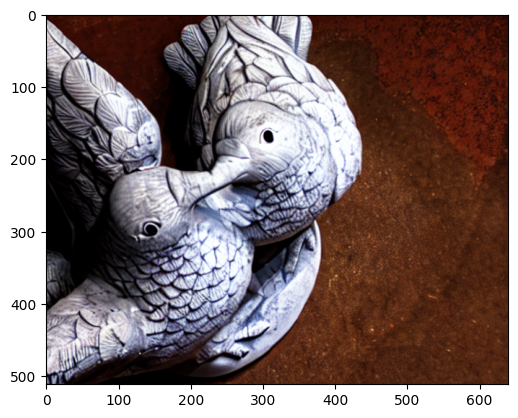

(512, 640, 3)
(512, 640)
(3, 512, 640)


In [ ]:
# Step 2. Perform depth filtering and fusion
point_dir = f'results/{args.dataset_name}/points'
os.makedirs(point_dir, exist_ok=True)
print('Fusing point clouds...')

for scan in ["scan106"]:
    print(f'Processing {scan} ...')
    
    # buffers for the final vertices of this scan
    vs = []
    v_colors = []
    # buffers storing the refined data of each ref view
    os.makedirs(f'results/{args.dataset_name}/image_refined/{scan}', exist_ok=True)
    image_refined = set()
    depth_refined = {}
    for meta in tqdm(list(filter(lambda x: x[0]==scan and x[2]==0, val_data.metas))[:args.max_ref_views]):
       
        try:
            ref_vid = meta[1]
            if ref_vid in image_refined: # not yet refined actually
                image_ref = read_refined_image(args.dataset_name, scan, ref_vid)
                depth_ref = depth_refined[ref_vid]
            else:
                if refine:
                    img_dir = f'./results/{args.dataset_name}/image_modified/{scan}'
                    image_ref = np.load(os.path.join(img_dir, f'{ref_vid:04d}_class6.npy'))[0]
                    print(image_ref.shape)
                    image_ref *= 255
                    image_ref = image_ref.transpose(1,2,0)
                    image_ref = image_ref.astype(np.uint8)
                    image_ref = cv2.resize(image_ref, tuple(args.img_wh))
                    plt.imshow(image_ref)
                    plt.show()
                    print(image_ref.shape)

                else:
                    image_ref = read_image(args.dataset_name, args.root_dir, scan, ref_vid,0)
                    image_ref = cv2.resize(image_ref, tuple(args.img_wh),
                                            interpolation=cv2.INTER_LINEAR)[:,:,::-1] # to RGB
                
                if read_gt:
                    depth_ref = read_pfm(f'{args.root_dir}/Depths/{scan}/depth_map_{ref_vid:04d}.pfm')[0]
                    depth_ref = cv2.resize(depth_ref, tuple(args.img_wh),
                                            interpolation=cv2.INTER_LINEAR)
                else:
                    if refine:
                        depth_ref = read_pfm(f'results/{args.dataset_name}/depth/' \
                                                f'{scan}/{scan}/depth_refined_{ref_vid:04d}.pfm')[0]
                        print(depth_ref.shape)
                    else:
                        depth_ref = read_pfm(f'results/{args.dataset_name}/depth/' \
                                            f'{scan}/{scan}/depth_{ref_vid:04d}.pfm')[0]
            if read_gt:
                proba_ref = np.ones_like(depth_ref)
            elif refine:
                proba_ref = read_pfm(f'results/{args.dataset_name}/depth/' \
                                    f'{scan}/{scan}/proba_refined_{ref_vid:04d}.pfm')[0]
                proba_ref = cv2.resize(proba_ref, None, fx=4, fy=4,
                                        interpolation=cv2.INTER_LINEAR)
            else:
                proba_ref = read_pfm(f'results/{args.dataset_name}/depth/' \
                                        f'{scan}/{scan}/proba_{ref_vid:04d}.pfm')[0]
                proba_ref = cv2.resize(proba_ref, None, fx=4, fy=4,
                                        interpolation=cv2.INTER_LINEAR)
            mask_conf = proba_ref > args.conf # confidence mask
            P_world2ref = read_proj_mat(args.dataset_name, val_data, scan, ref_vid)
            
            src_vids = meta[3]
            mask_geos = []
            depth_ref_reprojs = [depth_ref]
            image_src2refs = [image_ref]
            # for each src view, check the consistency and refine depth
            for src_vid in src_vids:
                if src_vid in image_refined: # use refined data of previous runs
                    image_src = read_refined_image(args.dataset_name, scan, src_vid)
                    depth_src = depth_refined[src_vid]
                else:
                    if refine:
                        img_dir = f'./results/{args.dataset_name}/image_modified/{scan}'
                        image_src = np.load(os.path.join(img_dir, f'{src_vid:04d}_class6.npy'))[0]
                        print(image_src.shape)
                        image_src *= 255
                        image_src = image_src.transpose(1,2,0)
                        image_src= image_src.astype(np.uint8)
                        image_src = cv2.resize(image_src, tuple(args.img_wh))
                    else: 
                        image_src = read_image(args.dataset_name, args.root_dir, scan, src_vid,6)
                        image_src = cv2.resize(image_src, tuple(args.img_wh),
                                                interpolation=cv2.INTER_LINEAR)[:,:,::-1] # to RGB




                    if read_gt:
                        depth_src = read_pfm(f'{args.root_dir}/Depths/{scan}/depth_map_{src_vid:04d}.pfm')[0]
                        depth_src = cv2.resize(depth_src, tuple(args.img_wh),
                                                interpolation=cv2.INTER_LINEAR)
                    else:
                        if refine:
                            depth_src = read_pfm(f'results/{args.dataset_name}/depth/' \
                                                f'{scan}/{scan}/depth_refined_{src_vid:04d}.pfm')[0]
                        else:
                            depth_src = read_pfm(f'results/{args.dataset_name}/depth/' \
                                                f'{scan}/{scan}/depth_{src_vid:04d}.pfm')[0]
                        

                   
                    depth_refined[src_vid] = depth_src
                P_world2src = read_proj_mat(args.dataset_name, val_data, scan, src_vid)
                depth_ref_reproj, mask_geo, image_src2ref = \
                    check_geo_consistency(depth_ref, P_world2ref,
                                            depth_src, P_world2src,
                                            image_ref, image_src, tuple(args.img_wh))
                depth_ref_reprojs += [depth_ref_reproj]
                image_src2refs += [image_src2ref]
                mask_geos += [mask_geo]
            mask_geo_sum = np.sum(mask_geos, 0)
            mask_geo_final = mask_geo_sum >= args.min_geo_consistent
            depth_refined[ref_vid] = \
                (np.sum(depth_ref_reprojs, 0)/(mask_geo_sum+1)).astype(np.float32)
            image_refined_ = \
                np.sum(image_src2refs, 0)/np.expand_dims((mask_geo_sum+1), -1)

            image_refined.add(ref_vid)
            save_refined_image(image_refined_, args.dataset_name, scan, ref_vid)
            mask_final = mask_conf & mask_geo_final
            
            # create the final points
            xy_ref = np.mgrid[:args.img_wh[1],:args.img_wh[0]][::-1]
            xyz_ref = np.vstack((xy_ref, np.ones_like(xy_ref[:1]))) * depth_refined[ref_vid]
            xyz_ref = xyz_ref.transpose(1,2,0)[mask_final].T # (3, N)
            color = image_refined_[mask_final] # (N, 3)
            xyz_ref_h = np.vstack((xyz_ref, np.ones_like(xyz_ref[:1])))
            xyz_world = (np.linalg.inv(P_world2ref) @ xyz_ref_h).T # (N, 4)
            xyz_world = xyz_world[::args.skip, :3]
            color = color[::args.skip]
            
            # append to buffers
            vs += [xyz_world]
            v_colors += [color]

        except Exception as e:
            # some scenes might not have depth prediction due to too few valid src views
            
            print(f'Error: {e}')
    # clear refined buffer
    image_refined.clear()
    depth_refined.clear()
    shutil.rmtree(f'results/{args.dataset_name}/image_refined/{scan}')

    # process all points in the buffers
    vs = np.ascontiguousarray(np.vstack(vs).astype(np.float32))
    v_colors = np.vstack(v_colors).astype(np.uint8)
    print(f'{scan} contains {len(vs)/1e6:.2f} M points')
    vs.dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4')]
    v_colors.dtype = [('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]

    vertex_all = np.empty(len(vs), vs.dtype.descr+v_colors.dtype.descr)
    for prop in vs.dtype.names:
        vertex_all[prop] = vs[prop][:, 0]
    for prop in v_colors.dtype.names:
        vertex_all[prop] = v_colors[prop][:, 0]
    if read_gt:
        el = PlyElement.describe(vertex_all, 'vertex')
        PlyData([el]).write(f'{point_dir}/{scan}_gt.ply')
    elif refine:
        el = PlyElement.describe(vertex_all, 'vertex')
        PlyData([el]).write(f'{point_dir}/{scan}_refine.ply')
    
    else:
        el = PlyElement.describe(vertex_all, 'vertex')
        PlyData([el]).write(f'{point_dir}/{scan}.ply')
    del vertex_all, vs, v_colors
shutil.rmtree(f'results/{args.dataset_name}/image_refined')

print('Done!')